# Machine Learning and Genetic Variations: Insights into Disease Classification

#### Abstract:

This study aimed to elucidate the relationship between the pathogenicity of genetic mutations and the classification of the resulting diseases, utilizing the ClinVar database. An intensive data cleaning process was performed, including handling missing values, detecting outliers, and eliminating irrelevant columns. During this phase, a critical observation was made: the allele frequencies for genetic mutations varied significantly across different databases. This discrepancy poses a significant challenge in the field of genomics, as it could potentially lead to misleading interpretations and outcomes in genetic disease classification.

Despite this obstacle, various machine learning models were deployed on the refined dataset. Initial models, however, struggled due to the imbalanced 'CLASS' target variable, achieving a less than ideal accuracy of 76% and an R-squared of -0.25.

Nevertheless, the exploration of the PolyPhen variable and 'Consequence' column yielded more promising results. The XGBoost model, when applied to the PolyPhen variable, reached an accuracy of 78.8% and an R-squared of 0.21. Further, the model targeted towards the 'Consequence' column resulted in an impressive accuracy of 93.4% and an R-squared of 0.957, indicating a strong model fit.

In conclusion, our study underscores the complexities involved in genetic mutation classifications, including significant variances in allele frequencies across databases. Despite early challenges, our research demonstrated the robust potential of machine learning in decoding these intricacies and provided a solid foundation for future research in genetic disease classification.

#### Link to Kaggle Dataset: 

https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting

# Research Question:

## What is the relationship between the pathogenicity of genetic mutations and the classification of consequent diseases?

In [159]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [161]:
df = pd.read_csv('clinvar_conflicting.csv', low_memory=False)

In [162]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [164]:
df.shape

(65188, 46)

## What is ClinVar?

ClinVar is a publicly accessible database that catalogs genetic variants and their clinical significance. It serves as a valuable resource for researchers, clinicians, and patients by providing information about the relationship between genetic mutations and human health. ClinVar aggregates data from various sources, including research studies, clinical laboratories, and expert reviews, to classify and interpret the impact of genetic variants on diseases and conditions. This curated knowledge base facilitates the understanding of how specific genetic mutations contribute to disease risk, treatment responses, and clinical outcomes, ultimately aiding in personalized medicine and genetic counseling.

# 1. Data Cleaning

The provided information suggests that the DataFrame comprises 46 parameters (fields) pertaining to the genetic mutation samples within the database. In order to ensure the integrity and reliability of subsequent analyses, it is imperative to conduct meticulous data cleaning procedures. Data cleaning entails comprehensive examination of null values, identification of outliers, and initial visualization of relationships between categorical and continuous variables. By undertaking these essential steps, one can mitigate the potential for inaccuracies in feature selection and model generation, thereby establishing a solid foundation for downstream analyses and insights.

#### Null Values

In [165]:
# create new dataframe with data type, nulls, & unique values
var_df = pd.DataFrame(columns=['variable_name', 'data_type', 'missing_percentage', 'flag', 'unique_values_count'])

missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

# create variables and flag as numeric or categorial
for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'
    
    # concat values obtained into a new dataframe called 'var_df'
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)

# sort variables by missing percentage value
var_df_sorted = var_df.sort_values(by='missing_percentage')
var_df_sorted.reset_index(drop=True, inplace=True)

var_df_sorted

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,Consequence,object,0.000000,categorical,48
2,ORIGIN,int64,0.000000,numeric,31
3,IMPACT,object,0.000000,categorical,4
4,CLNVC,object,0.000000,categorical,7
5,CLNHGVS,object,0.000000,categorical,65188
6,CLASS,int64,0.000000,numeric,2
7,CLNDN,object,0.000000,categorical,9260
8,AF_TGP,float64,0.000000,numeric,2087
9,AF_EXAC,float64,0.000000,numeric,6667


The presented chart highlights columns exhibiting an exceedingly high percentage of missing values, with nine columns surpassing a 99.5% missing threshold. These columns contain minimal non-null values, amounting to less than 0.5% of the data. To maintain the integrity and focus of the project, it is prudent to exclude columns with over 99% missing values, resulting in the removal of the nine aforementioned columns from the dataset.

In [166]:
var_df = var_df_sorted.copy()

# Set the threshold for missing values percentage and drop if necessary
threshold = 99  
var_df = var_df[var_df['missing_percentage'] <= threshold]

var_df

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,Consequence,object,0.000000,categorical,48
2,ORIGIN,int64,0.000000,numeric,31
3,IMPACT,object,0.000000,categorical,4
4,CLNVC,object,0.000000,categorical,7
5,CLNHGVS,object,0.000000,categorical,65188
6,CLASS,int64,0.000000,numeric,2
7,CLNDN,object,0.000000,categorical,9260
8,AF_TGP,float64,0.000000,numeric,2087
9,AF_EXAC,float64,0.000000,numeric,6667


Now that columns have been removed, they must be removed again from the original 'df' dataframe. The chart above is a dataframe extracted from the initial dataframe for analysis.

In [167]:
# Set the threshold for missing values percentage and drop

threshold = 99  

missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist() 

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  CLNVI             27659 non-null  object 
 12  MC                64342 non-null  object 
 13  ORIGIN            65188 non-null  int64  
 14  CLASS             65188 non-null  int64  
 15  Allele            65188 non-null  object 
 16  Consequence       65188 non-null  object

Having removed the initial set of columns, we are now poised to delve into the exploration of variable relationships, thereby unraveling potential inconsistencies and errors embedded within the data. To gain valuable insights, a comprehensive heat matrix analysis will be employed, enabling the identification of correlations among numeric variables. This initial step promises to shed light on significant patterns and dependencies, paving the way for informed decision-making and further data analysis.

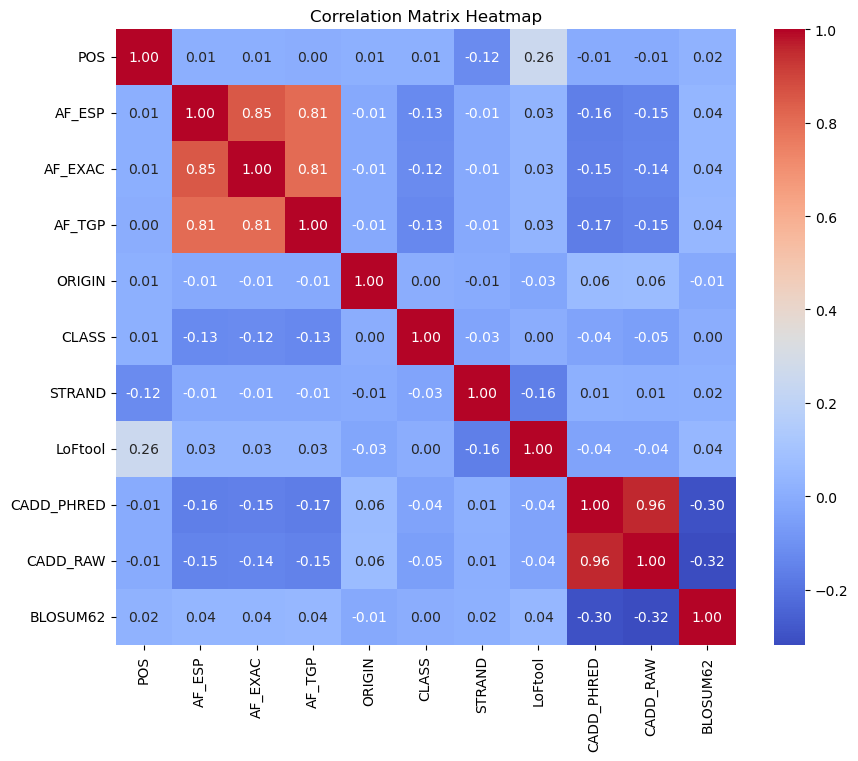

In [168]:
# filter numerical columns and create correlation heat matrix map
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr() # calculate correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f') 
plt.title('Correlation Matrix Heatmap')
plt.show()

In [169]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Amino_acids,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,not_specified,NC_000001.10:g.1168180G>C,...,E/D,gaG/gaC,1.0,NaN,tolerated,benign,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",Spinocerebellar_ataxia_21|not_provided,NC_000001.10:g.1470752G>A,...,P/L,cCg/cTg,-1.0,OK,deleterious_low_confidence,benign,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",Strabismus|Nystagmus|Hypothyroidism|Intellectu...,NC_000001.10:g.1737942A>G,...,I/T,aTc/aCc,-1.0,OK,deleterious,probably_damaging,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",Shprintzen-Goldberg_syndrome|not_provided,NC_000001.10:g.2160305G>A,...,G/S,Ggc/Agc,1.0,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",Shprintzen-Goldberg_syndrome,NC_000001.10:g.2160305G>T,...,G/C,Ggc/Tgc,1.0,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


#### Drop Unnecessary Variables

Within the context of this project and experiment, there exists a selection of columns within the main 'df' dataframe that can be readily discarded due to their lack of relevance or redundancy:

1. BAM_EDIT: Pertaining to Binary Map Alignment, it does not offer pertinent information for this analysis.
2. INTRON: With a significantly low number of non-null values and containing dates, it does not align with the objectives of this study.
3. EXON: Comprising date-related information, it is not applicable since this project does not involve time series analysis.
4. CLNDISB: Providing MedGen database identifiers, it does not contribute to the current investigation.
5. CLNHGVS: Serving as a database identifier, it does not bear relevance for the purposes of this study.
6. MC: A redundant column replicating the information found in the 'Consequence' column alongside an additional database identifier.
7. CLNVI: Representing a lab location identifier, it holds no significance in the present project.
8. SYMBOL: Constituting another identifier, it duplicates existing information and can be omitted.
9. Feature: The information it encompasses is already included in the 'Consequence' column.
10. Feature_type: The information it entails is already included in the 'Consequence' column.
11. BIOTYPE: The information it encompasses is already included in the 'Consequence' column.
12. CADD_RAW: While related to CADD_PHRED, only CADD_PHRED is essential for this genetic mutation analysis due to its usage of a more manageable scale.
13. Allele: As it contains the same values as the 'ALT' column, it can be regarded as a duplicate entry and removed accordingly.

By eliminating these redundant or irrelevant columns, the data will be streamlined and more focused, enhancing the accuracy and efficiency of subsequent analyses.

In [170]:
df.drop(['BAM_EDIT', 'EXON', 'CLNDISDB', 'CLNHGVS', 
         'MC', 'CLNVI', 'SYMBOL', 'Feature', 'Feature_type', 
         'BIOTYPE', 'INTRON', 'CADD_RAW', 'Allele'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Consequence       65188 non-null  object 
 12  IMPACT            65188 non-null  object 
 13  cDNA_position     56304 non-null  object 
 14  CDS_position      55233 non-null  object 
 15  Protein_position  55233 non-null  object 
 16  Amino_acids       55184 non-null  object

In [171]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POS         65188 non-null  int64  
 1   AF_ESP      65188 non-null  float64
 2   AF_EXAC     65188 non-null  float64
 3   AF_TGP      65188 non-null  float64
 4   ORIGIN      65188 non-null  int64  
 5   CLASS       65188 non-null  int64  
 6   STRAND      65174 non-null  float64
 7   LoFtool     60975 non-null  float64
 8   CADD_PHRED  64096 non-null  float64
 9   CADD_RAW    64096 non-null  float64
 10  BLOSUM62    25593 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 5.5 MB


In [172]:
numerical_columns.head()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,CLASS,STRAND,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1168180,0.0771,0.10020,0.1066,1,0,1.0,NaN,1.053,-0.208682,2.0
1,1470752,0.0000,0.00000,0.0000,1,0,-1.0,NaN,31.000,6.517838,-3.0
2,1737942,0.0000,0.00001,0.0000,35,1,-1.0,NaN,28.100,6.061752,-1.0
3,2160305,0.0000,0.00000,0.0000,33,0,1.0,NaN,22.500,3.114491,NaN
4,2160305,0.0000,0.00000,0.0000,33,0,1.0,NaN,24.700,4.766224,-3.0


In [173]:
object_cols = df.select_dtypes(include=['object'])
object_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CHROM             65188 non-null  object
 1   REF               65188 non-null  object
 2   ALT               65188 non-null  object
 3   CLNDN             65188 non-null  object
 4   CLNVC             65188 non-null  object
 5   Consequence       65188 non-null  object
 6   IMPACT            65188 non-null  object
 7   cDNA_position     56304 non-null  object
 8   CDS_position      55233 non-null  object
 9   Protein_position  55233 non-null  object
 10  Amino_acids       55184 non-null  object
 11  Codons            55184 non-null  object
 12  SIFT              24836 non-null  object
 13  PolyPhen          24796 non-null  object
dtypes: object(14)
memory usage: 7.0+ MB


In [174]:
object_cols.head()

,CHROM,REF,ALT,CLNDN,CLNVC,Consequence,IMPACT,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,SIFT,PolyPhen
0,1,G,C,not_specified,single_nucleotide_variant,missense_variant,MODERATE,552,522,174,E/D,gaG/gaC,tolerated,benign
1,1,G,A,Spinocerebellar_ataxia_21|not_provided,single_nucleotide_variant,missense_variant,MODERATE,523,509,170,P/L,cCg/cTg,deleterious_low_confidence,benign
2,1,A,G,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,single_nucleotide_variant,missense_variant,MODERATE,632,239,80,I/T,aTc/aCc,deleterious,probably_damaging
3,1,G,A,Shprintzen-Goldberg_syndrome|not_provided,single_nucleotide_variant,missense_variant,MODERATE,132,100,34,G/S,Ggc/Agc,NaN,NaN
4,1,G,T,Shprintzen-Goldberg_syndrome,single_nucleotide_variant,missense_variant,MODERATE,132,100,34,G/C,Ggc/Tgc,NaN,NaN


To facilitate initial visualization, the object and numerical columns have been separated. However, diligent observation reveals the presence of potential errors, necessitating their resolution. As we proceed, these errors will be addressed and rectified.

In [175]:
# Create an empty DataFrame to store the columns with missing values
still_missing = pd.DataFrame()

# Iterate over the columns of the DataFrame and isolate missing columns
for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

print("Columns with missing values:")
still_missing.info()

Columns with missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     56304 non-null  object 
 1   CDS_position      55233 non-null  object 
 2   Protein_position  55233 non-null  object 
 3   Amino_acids       55184 non-null  object 
 4   Codons            55184 non-null  object 
 5   STRAND            65174 non-null  float64
 6   SIFT              24836 non-null  object 
 7   PolyPhen          24796 non-null  object 
 8   LoFtool           60975 non-null  float64
 9   CADD_PHRED        64096 non-null  float64
 10  BLOSUM62          25593 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [176]:
still_missing.nunique()

cDNA_position       13970
CDS_position        13663
Protein_position     7339
Amino_acids          1262
Codons               2220
STRAND                  2
SIFT                    4
PolyPhen                4
LoFtool              1195
CADD_PHRED           9324
BLOSUM62                6
dtype: int64

#### Forward Fill and Interpolation of Remaining Nulls

In order to handle missing values in the dataset, a forward fill (ffill) approach was employed for both the 'BLOSUM62' column and object columns. This method was selected to propagate the last observed non-null value forward, maintaining the temporal coherence of the data. BLOSUM62 was also transformed via forward fill because of it's low count categorical nature. For numerical columns, interpolation was utilized to estimate missing values based on existing data points, ensuring a smooth transition and preserving the underlying trends and patterns in the numerical data.

In [177]:
for column in still_missing.columns:
    if column == 'BLOSUM62':
        # Fill missing values in the 'BLOSUM62' column with forward fill (ffill)
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'object':
        # Fill missing values in object columns with forward fill (ffill)
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'float64':
        # Interpolate missing values in float64 columns
        still_missing[column] = still_missing[column].interpolate()

# Fill missing values in 'LoFtool' column with 0
still_missing['LoFtool'] = still_missing['LoFtool'].fillna(0)

# Check the updated DataFrame information
still_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     65188 non-null  object 
 1   CDS_position      65188 non-null  object 
 2   Protein_position  65188 non-null  object 
 3   Amino_acids       65188 non-null  object 
 4   Codons            65188 non-null  object 
 5   STRAND            65188 non-null  float64
 6   SIFT              65188 non-null  object 
 7   PolyPhen          65188 non-null  object 
 8   LoFtool           65188 non-null  float64
 9   CADD_PHRED        65188 non-null  float64
 10  BLOSUM62          65188 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [178]:
# update main dataframe 

df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Consequence       65188 non-null  object 
 12  IMPACT            65188 non-null  object 
 13  cDNA_position     65188 non-null  object 
 14  CDS_position      65188 non-null  object 
 15  Protein_position  65188 non-null  object 
 16  Amino_acids       65188 non-null  object

All null values have been filled in the dataframe. The next step in cleaning is to handle abnormal sample values and visualize outliers and distributions. To do this, we must encode the object columns. 

# 2. Data Exploratory Analysis

#### Outliers and Transformations

In [179]:
df.nunique()

CHROM                  24
POS                 63115
REF                   866
ALT                   458
AF_ESP               2842
AF_EXAC              6667
AF_TGP               2087
CLNDN                9260
CLNVC                   7
ORIGIN                 31
CLASS                   2
Consequence            48
IMPACT                  4
cDNA_position       13970
CDS_position        13663
Protein_position     7339
Amino_acids          1262
Codons               2220
STRAND                  7
SIFT                    4
PolyPhen                4
LoFtool              5199
CADD_PHRED          10111
BLOSUM62                6
dtype: int64

In [180]:
df['REF'].unique()

array(['G', 'A', 'T', 'C', 'CAG', 'GCCCTCCTCTGAGTCTTCCTCCCCTTCCCGTA',
       'AG', 'TTCCTCC', 'TTCC', 'CTT', 'CAGACCGCAGGCTGGAGACCA',
       'AACACCCGCAAGAAGCCGGTAGTCT', 'CCAGGCTGGGGAAG', 'TAGAG', 'TG', 'TC',
       'GGAAGAA', 'ATGAGG', 'TACTA', 'AC', 'CG', 'CT', 'TA',
       'AGCCGCCGCCAGCCGCAGCCATGGGCCGGGCCCGGCCGGGCCAACGCGGGCCGCCCAGCCCCGGCCCCGCCGCGCAGCCTCCCGCGCCACCGC',
       'CCCCGCCGCCGCCAGCAGCCTGGGCAA', 'GA', 'CCA', 'TACG',
       'GCCTGCACAAGGA', 'CTAAAGT', 'TGGAGGGAG', 'TT', 'CCT',
       'AGACCGAAAGAAATTATCCAGGACTTGCTGGCCCATGCGGGGCTTTTTCC', 'TGTTG',
       'CAAG', 'GTAGTGCC', 'AT', 'AGGTCACGGACG', 'GC', 'CAA',
       'TAGCCCAGGCC', 'TCCTATTTCCCCTA', 'CCCAA', 'CAGA',
       'GAACCCTGCAAAAAGTGACACTATC', 'ACTG', 'TTTG', 'TTTAA', 'AAAG',
       'GAAGT', 'ATGAC', 'GTTGCAATGGGAGC', 'CAGTT', 'TTTTG', 'TAGA',
       'GAGA', 'AGAG', 'AGAGGAG', 'CAGG', 'TGGA', 'CAGAG', 'CAGAGAGAGAG',
       'GTGCCCCAGGGCCAAC', 'GGT', 'AAC', 'AGCGCACCGTCTTT', 'TAGAC', 'TGA',
       'GAAAAA', 'CCATCAT', 'C

IMPORTANT NOTE:

Regarding the 'REF' and 'ALT' columns denoting the original allele and altered allele (mutation), it is customary for these values to consist of a single letter representing one of the four nucleotide bases: G, C, A, T. However, upon examination using the unique counts function, it becomes evident that these columns contain an excessive number of unique values. This can be attributed to anomalous entries where multiple letters are present instead of a single letter. These anomalies represent a very small portion of the data. Consequently, rows containing such multi-letter values will be excluded from further analysis to ensure data integrity and adherence to the expected format.

In [181]:
# Define the allowed values
allowed_values = ['A', 'T', 'C', 'G']

# Iterate over each column and isolate allowed values
for column in ['REF', 'ALT']:
    df = df[df[column].isin(allowed_values)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  object 
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  object 
 3   ALT               61281 non-null  object 
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  object 
 8   CLNVC             61281 non-null  object 
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  object 
 12  IMPACT            61281 non-null  object 
 13  cDNA_position     61281 non-null  object 
 14  CDS_position      61281 non-null  object 
 15  Protein_position  61281 non-null  object 
 16  Amino_acids       61281 non-null  object

In [182]:
df.nunique()

CHROM                  24
POS                 59822
REF                     4
ALT                     4
AF_ESP               2827
AF_EXAC              6568
AF_TGP               2064
CLNDN                8726
CLNVC                   1
ORIGIN                 30
CLASS                   2
Consequence            23
IMPACT                  4
cDNA_position       12010
CDS_position        11801
Protein_position     6381
Amino_acids           305
Codons                766
STRAND                  7
SIFT                    4
PolyPhen                4
LoFtool              4940
CADD_PHRED           9225
BLOSUM62                6
dtype: int64

In [183]:
# Create a copy of df to preserve the cleaned dataframe
# before encoding
df_original = df.copy()
df_factorized = df.copy()

# Iterate over each column in the dataframe
for column in df_factorized.columns:
    # Check if the column's dtype is 'object'
    if df_factorized[column].dtype == 'object':
        df_factorized[column] = pd.factorize(df_factorized[column])[0]

df_factorized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   CLNVC             61281 non-null  int64  
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  int64  
 12  IMPACT            61281 non-null  int64  
 13  cDNA_position     61281 non-null  int64  
 14  CDS_position      61281 non-null  int64  
 15  Protein_position  61281 non-null  int64  
 16  Amino_acids       61281 non-null  int64 

Reason for Factorized Encoding:

This type of encoding was used to assign a numerical value to every unique value in the object columns without introducing any sort of rank or compromising dimensionality. One hot encoding was not chosen because it significantly increased the dimensionality of the large dataset, reducing efficiency. Additionally, label encoding was not chosen because it introduces rank into the unique values of the object columns. Currently, all object columns are considered nominal and shall be treated as such.

In [184]:
df = df_factorized
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   CLNVC             61281 non-null  int64  
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  int64  
 12  IMPACT            61281 non-null  int64  
 13  cDNA_position     61281 non-null  int64  
 14  CDS_position      61281 non-null  int64  
 15  Protein_position  61281 non-null  int64  
 16  Amino_acids       61281 non-null  int64 

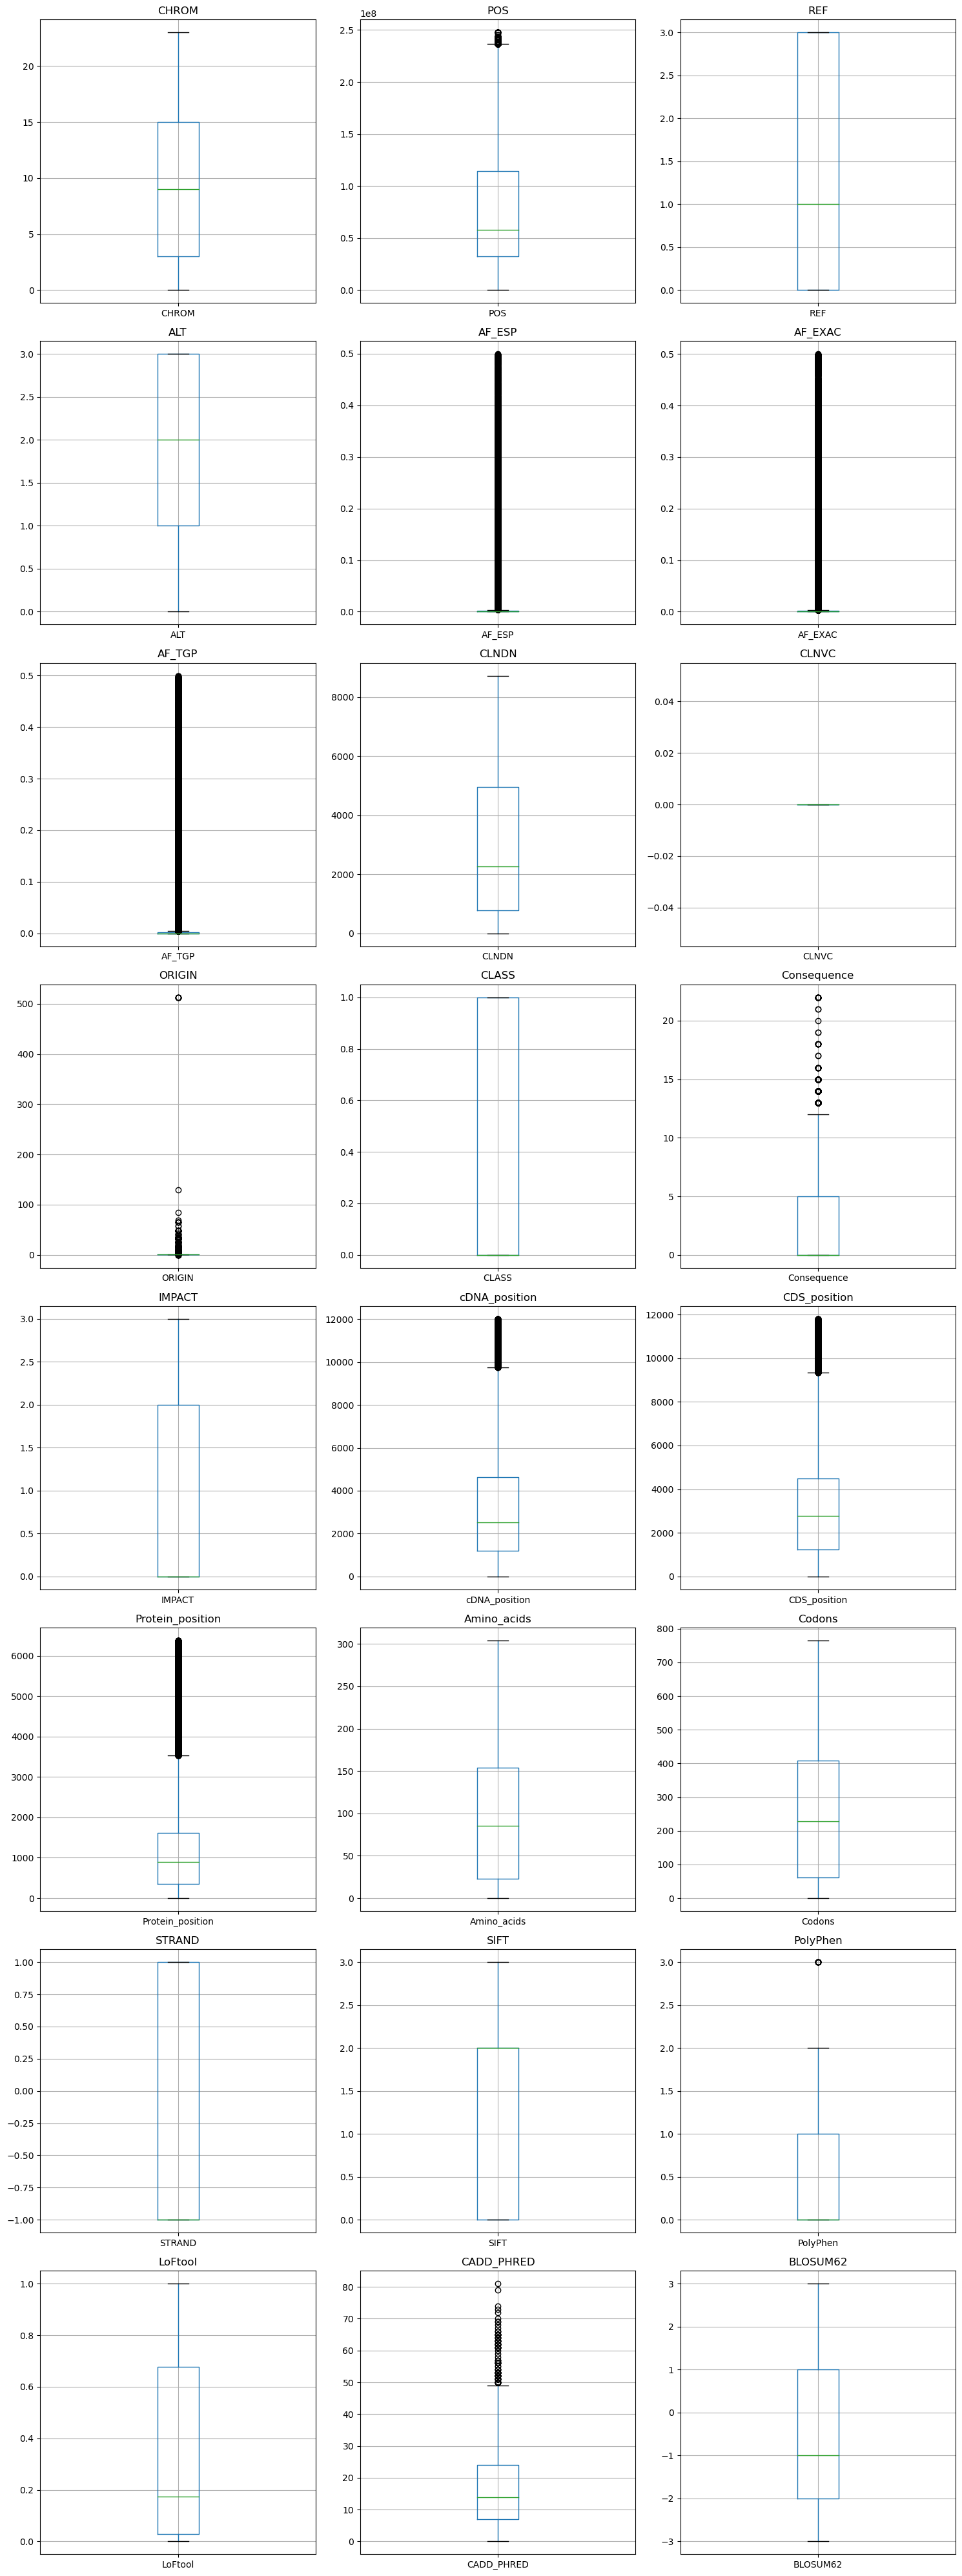

In [185]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Several boxplots in the visualizations above exhibit notable outliers, with particular emphasis on the allele frequency columns: AF_ESP, AF_EXAC, and AF_TGP. These columns hold significant relevance for the current project, as indicated by their high correlations with other variables, potentially impacting the model's performance.

Allele frequency measures play a pivotal role in population genetics and genomic research, enabling the examination of genetic variant prevalence and distribution among diverse populations. They provide valuable insights into variant impact on health, disease susceptibility, and genetic diversity. Although these variables theoretically represent the same value, each column's value was derived from distinct sources:

1. AF_ESP (Allele Frequency in the NHLBI Exome Sequencing Project) offers allele frequency data sourced from the NHLBI project, which sequenced exomes to investigate genetic diseases.
2. AF_EXAC (Allele Frequency in the Exome Aggregation Consortium) is an extensive database consolidating allele frequency information from large-scale sequencing initiatives like ExAC, contributing to a comprehensive understanding of genetic variation.
3. AF_TGP (Allele Frequency in the 1000 Genomes Project) encompasses allele frequency details derived from the ambitious 1000 Genomes Project, which aimed to create a comprehensive catalog of genetic variations across human populations by sequencing numerous individuals.

By comprehending the significance and origin of these allele frequency columns, researchers can leverage their insights to gain a deeper understanding of genetic variants and their implications in the context of the project at hand.

#### Allele Frequency Visualization

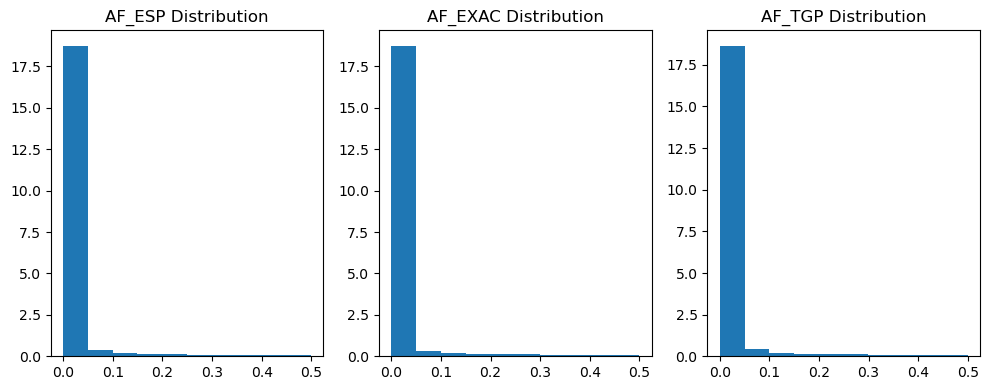

In [186]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

# Plot histograms for each column

ax1.hist(df['AF_ESP'], bins=10, density=True)
ax1.set_title('AF_ESP Distribution')


ax2.hist(df['AF_EXAC'], bins=10, density=True)
ax2.set_title('AF_EXAC Distribution')


ax3.hist(df['AF_TGP'], bins=10, density=True)
ax3.set_title('AF_TGP Distribution')

plt.tight_layout()

plt.show()

The distributions of allele frequencies displayed above exhibit similar patterns and significant right-skewness. Additionally, the absence of missing values (0% missing) and high correlation among all three columns further suggest their similarity.

However, a crucial aspect requires attention. Despite the columns appearing identical and having no missing values, it is important to acknowledge that in the original database, missing values are labeled as "0" in these columns. Consequently, when iterating through the column, Python interprets these "0" values as non-null rather than null.

To gain deeper insights into the actual missing values within the columns labeled as "0," let us conduct a thorough exploration.

In [187]:
allele_df = df[['AF_ESP', 'AF_EXAC', 'AF_TGP']]

allele_df.info()

# initiate count of three new variables

esp_zeros = 0
exac_zeros = 0
tgp_zeros = 0

# iterate through allele_df and print count of zeroes 

for column in allele_df.columns:
    column_values = allele_df[column].values
    zeros_count = len(column_values[column_values == 0])
    
    if column == 'AF_ESP':
        esp_zeros += zeros_count
    elif column == 'AF_EXAC':
        exac_zeros += zeros_count
    elif column == 'AF_TGP':
        tgp_zeros += zeros_count

print("Count of zeroes (missing values) in AF_ESP column:", esp_zeros)
print("Count of zeroes (missing values) in AF_EXAC column:", exac_zeros)
print("Count of zeroes (missing values) in AF_TGP column:", tgp_zeros)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   61281 non-null  float64
 1   AF_EXAC  61281 non-null  float64
 2   AF_TGP   61281 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB
Count of zeroes (missing values) in AF_ESP column: 32042
Count of zeroes (missing values) in AF_EXAC column: 20858
Count of zeroes (missing values) in AF_TGP column: 34310


In [188]:
esp_missing = round((esp_zeros / len(allele_df)) * 100, 2)
exac_missing = round((exac_zeros / len(allele_df)) * 100, 2)
tgp_missing = round((tgp_zeros / len(allele_df)) * 100, 2)

print("Percentage of actual missing values in AF_ESP column:", esp_missing)
print("Percentage of actual missing values in AF_EXAC column:", exac_missing)
print("Percentage of actual missing values in AF_TGP column:", tgp_missing)

Percentage of actual missing values in AF_ESP column: 52.29
Percentage of actual missing values in AF_EXAC column: 34.04
Percentage of actual missing values in AF_TGP column: 55.99


The three columns exhibit varying counts of zero, indicating different numbers of actual null values present within each. ESP and TGP share similar missing percentages, with ESP at 52.29% and TGP at 55.99%. On the other hand, EXAC displays a lower missing percentage of 34.04%. This discrepancy suggests that the EXAC column may be more comprehensive in terms of allele frequency data collection. However, it is crucial to approach these observations with scientific caution, as the mere presence of differences does not necessarily imply significance. It is important to remember that association does not imply causation.

The subsequent step involves visualizing the distributions after removing the null values, which will provide further insights into the data.

In [189]:
for column in allele_df.columns:
    allele_df.loc[allele_df[column] == 0, column] = None

allele_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   29239 non-null  float64
 1   AF_EXAC  40423 non-null  float64
 2   AF_TGP   26971 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB


The 'allele_df' dataframe above now has the correct count of non-null values in each column.

In [190]:
# Define the methods for filling null values
methods = ['mean', 'median', 'interpolation']

# Calculate skewness and kurtosis for original DataFrame
original_skewness = allele_df.skew()
original_kurtosis = allele_df.kurtosis()

# Create a dictionary to store the results
results = {}

# Iterate over the methods
for method in methods:
    # Fill null values using the respective method
    if method == 'mean':
        filled_df = allele_df.fillna(allele_df.mean())
    elif method == 'median':
        filled_df = allele_df.fillna(allele_df.median())
    elif method == 'interpolation':
        filled_df = allele_df.interpolate()
    
    # Calculate skewness and kurtosis
    skewness = filled_df.skew()
    kurtosis = filled_df.kurtosis()
    
    # Store the results in the dictionary
    results[method] = {'skewness': skewness, 'kurtosis': kurtosis}

# Print the results
for method in methods:
    print(f"DataFrame with {method.capitalize()}-Filled Null Values:")
    print("Skewness:\n", results[method]['skewness'])
    print("Kurtosis:\n", results[method]['kurtosis'])
    print()


DataFrame with Mean-Filled Null Values:
Skewness:
 AF_ESP     5.075619
AF_EXAC    5.203414
AF_TGP     4.909067
dtype: float64
Kurtosis:
 AF_ESP     29.240401
AF_EXAC    29.424542
AF_TGP     27.715173
dtype: float64

DataFrame with Median-Filled Null Values:
Skewness:
 AF_ESP     5.339052
AF_EXAC    5.328660
AF_TGP     5.227334
dtype: float64
Kurtosis:
 AF_ESP     30.488536
AF_EXAC    30.064269
AF_TGP     29.190748
dtype: float64

DataFrame with Interpolation-Filled Null Values:
Skewness:
 AF_ESP     4.117839
AF_EXAC    4.631401
AF_TGP     3.797907
dtype: float64
Kurtosis:
 AF_ESP     18.463492
AF_EXAC    22.978133
AF_TGP     15.628036
dtype: float64



The skewness and kurtosis values for the three types of null value filling are presented above. It has been observed that interpolation yields the least skewness and kurtosis on the data. Therefore, for the duration of the project, interpolation will be utilized for all three columns.

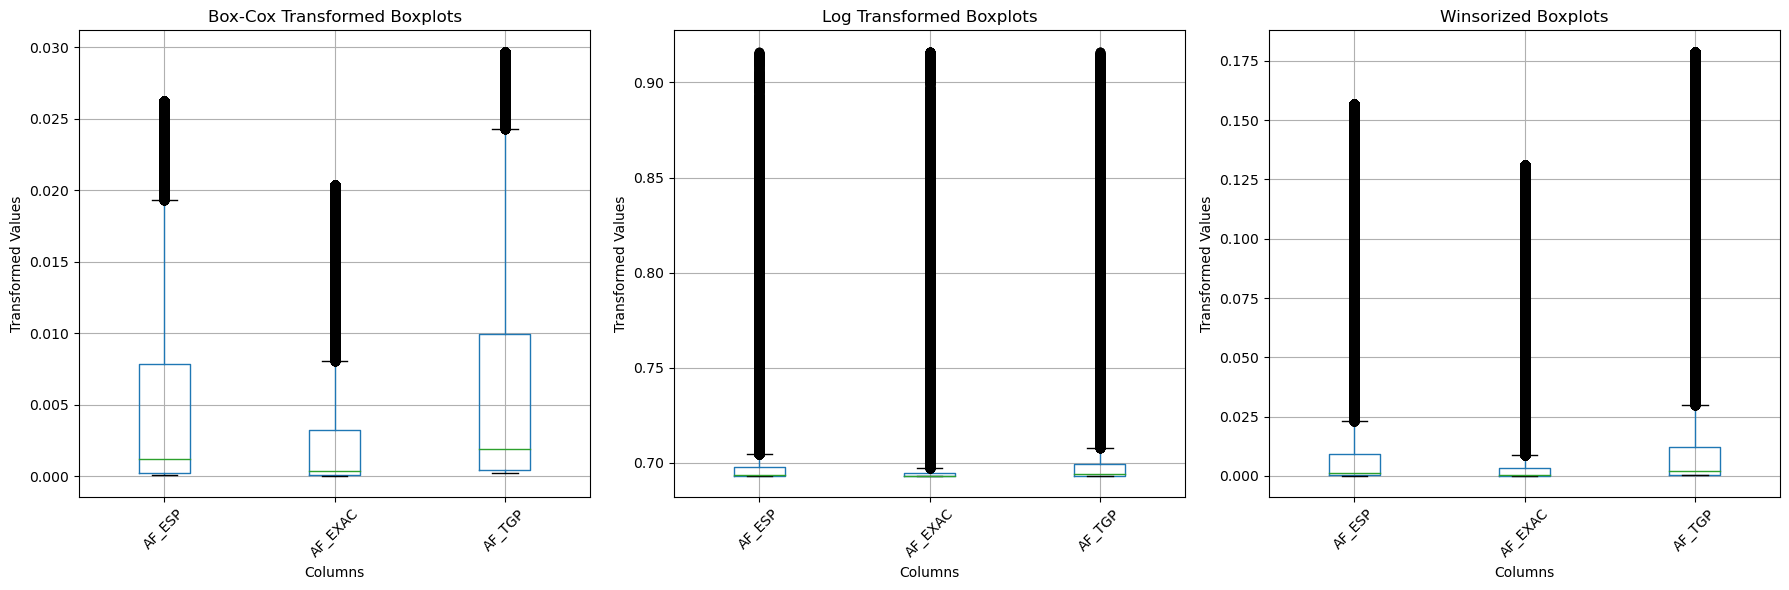

In [191]:
allele_df = allele_df.interpolate()

# Apply Box-Cox transformation to the DataFrame
allele_df_boxcox = allele_df.copy()
for column in allele_df_boxcox.columns:
    transformed_data, _ = boxcox(allele_df_boxcox[column].dropna() + 1)  # Add 1 to avoid zero values
    allele_df_boxcox[column].loc[~allele_df_boxcox[column].isna()] = transformed_data

log_constant = 1
allele_df_log = np.log1p(allele_df + log_constant)

# Apply winsorization to the DataFrame
allele_df_winsorized = allele_df.copy()
for column in allele_df_winsorized.columns:
    allele_df_winsorized[column] = winsorize(allele_df_winsorized[column].dropna(), limits=[0.05, 0.05])

# Create boxplots of transformed columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Box-Cox transformed boxplots
allele_df_boxcox.boxplot(ax=axes[0])
axes[0].set_title("Box-Cox Transformed Boxplots")
axes[0].set_xticklabels(allele_df_boxcox.columns, rotation=45)
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Transformed Values")

# Log transformed boxplots
allele_df_log.boxplot(ax=axes[1])
axes[1].set_title("Log Transformed Boxplots")
axes[1].set_xticklabels(allele_df_log.columns, rotation=45)
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Transformed Values")

# Winsorized boxplots
allele_df_winsorized.boxplot(ax=axes[2])
axes[2].set_title("Winsorized Boxplots")
axes[2].set_xticklabels(allele_df_winsorized.columns, rotation=45)
axes[2].set_xlabel("Columns")
axes[2].set_ylabel("Transformed Values")

# Adjusting the layout
plt.tight_layout()

# Display the plot
plt.show()


Considering the boxplot representations above, it becomes evident that the Box-Cox transformation yields the most effective transformation for handling outliers in all three columns. Therefore, it is appropriate to update our main dataframe accordingly to incorporate the transformed values.

In [192]:
df.update(allele_df_boxcox)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   CLNVC             61281 non-null  int64  
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  int64  
 12  IMPACT            61281 non-null  int64  
 13  cDNA_position     61281 non-null  int64  
 14  CDS_position      61281 non-null  int64  
 15  Protein_position  61281 non-null  int64  
 16  Amino_acids       61281 non-null  int64 

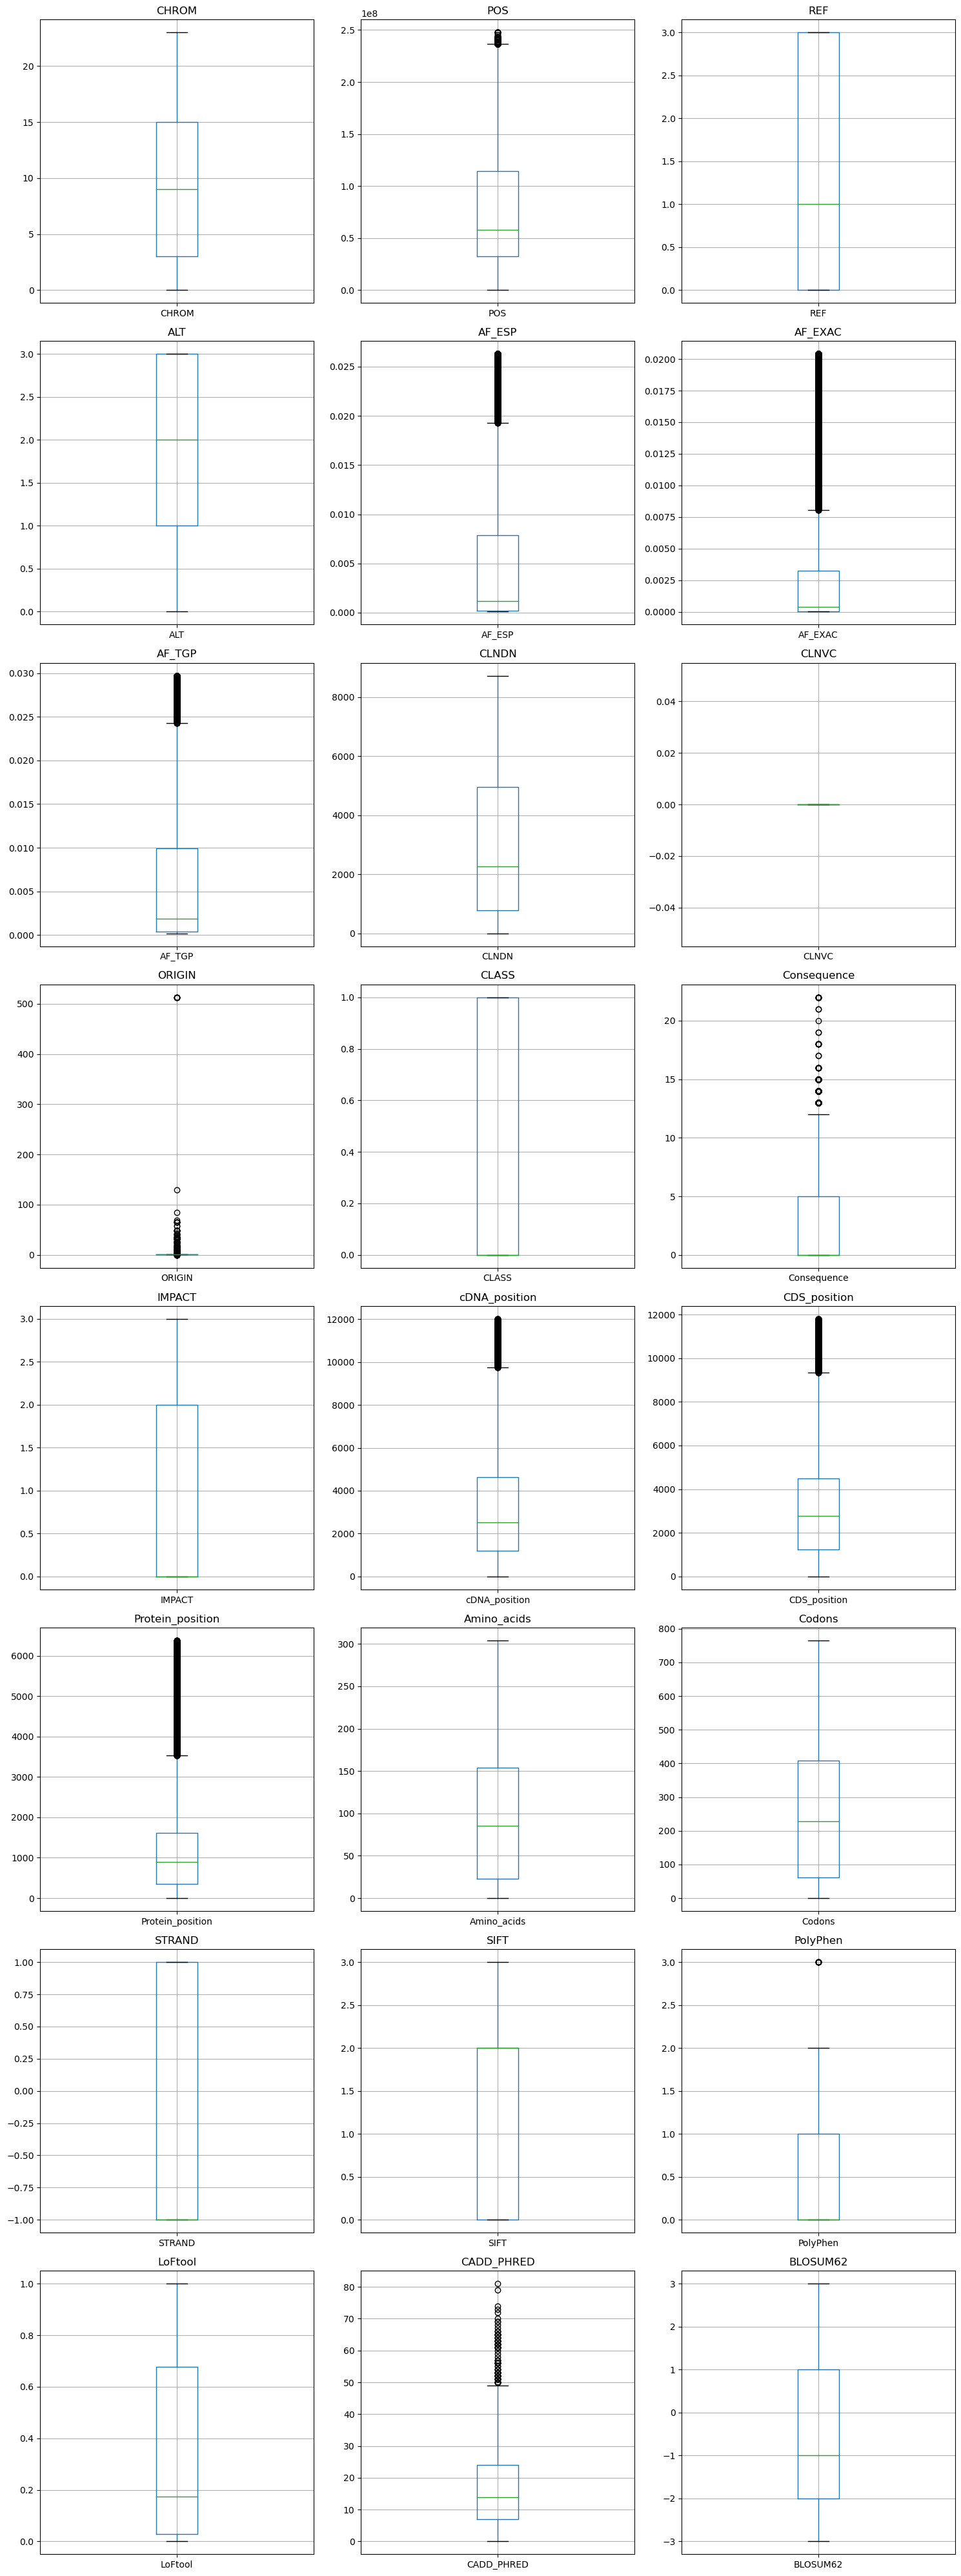

In [193]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [194]:
# Calculate z-scores for each column
z_scores = df.apply(stats.zscore)

# Identify outliers using z-score threshold
z_score_threshold = 3  # Adjust the threshold as needed

# Calculate the number of outliers for each column
num_outliers = (np.abs(z_scores) > z_score_threshold).sum()

# Print the number of outliers for each column
print("Number of Outliers:")
print(num_outliers)


Number of Outliers:
CHROM                  0
POS                    0
REF                    0
ALT                    0
AF_ESP                 0
AF_EXAC                0
AF_TGP                 0
CLNDN                  0
CLNVC                  0
ORIGIN               368
CLASS                  0
Consequence         1034
IMPACT                 0
cDNA_position        299
CDS_position         389
Protein_position    1882
Amino_acids           34
Codons                 0
STRAND                 0
SIFT                   0
PolyPhen              14
LoFtool                0
CADD_PHRED           162
BLOSUM62               0
dtype: int64


C:\Users\Jody\AppData\Local\Temp\ipykernel_36156\3471927310.py:2: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  z_scores = df.apply(stats.zscore)


After a thorough attempt to address outliers, a few columns still present some with a z-score over 3. Despite efforts to further normalize these columns, the outliers persist. Consequently, I've decided to keep these columns in their current form for now. 

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   CLNVC             61281 non-null  int64  
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  int64  
 12  IMPACT            61281 non-null  int64  
 13  cDNA_position     61281 non-null  int64  
 14  CDS_position      61281 non-null  int64  
 15  Protein_position  61281 non-null  int64  
 16  Amino_acids       61281 non-null  int64 

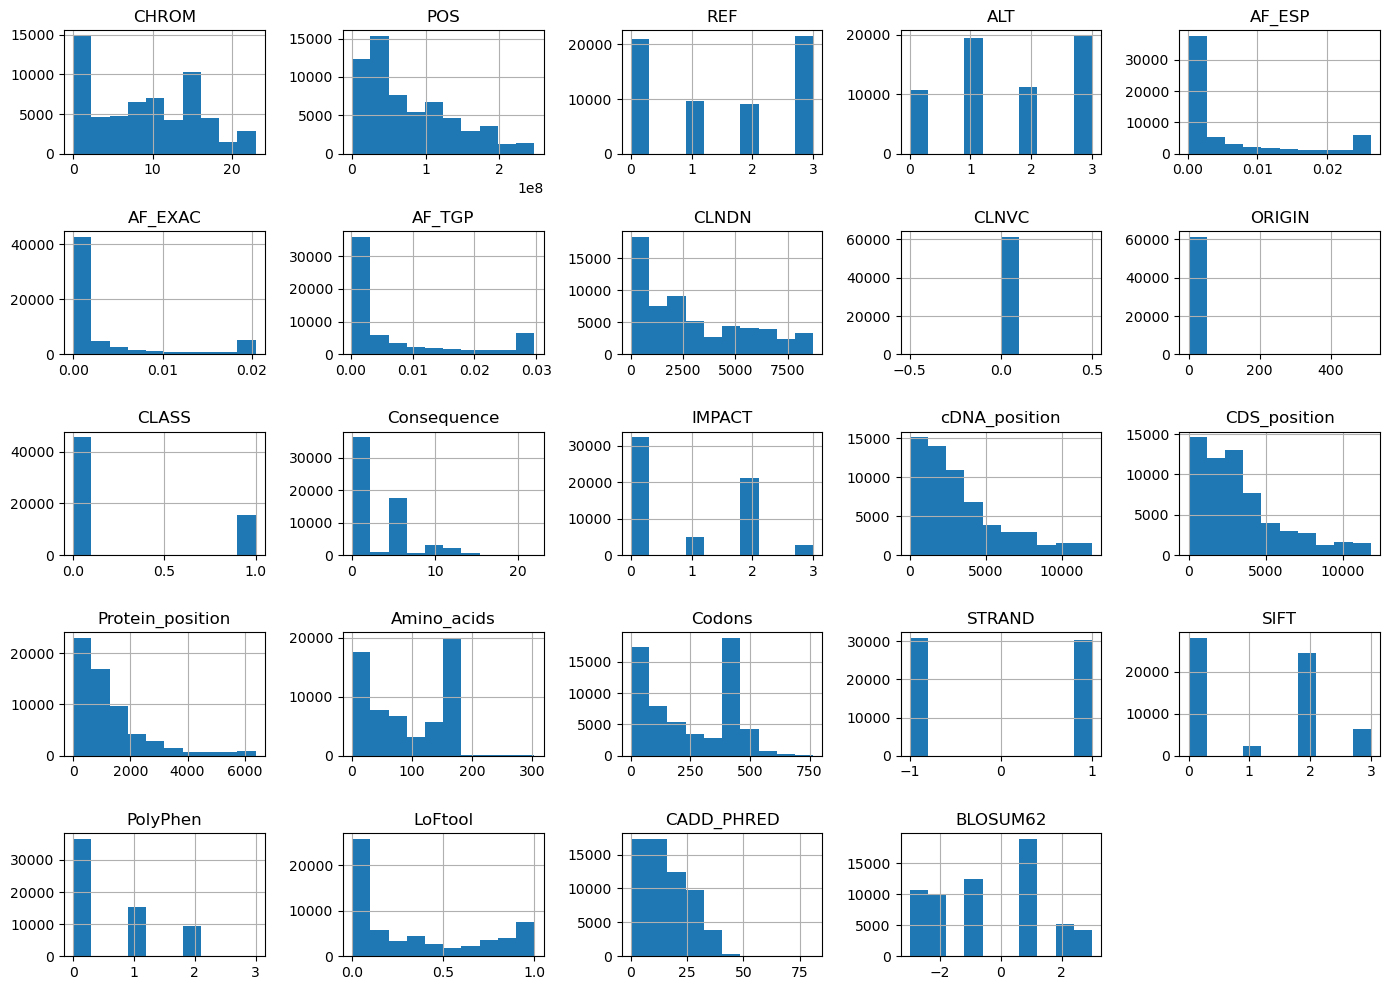

In [196]:
# Plot histograms of all columns with larger size
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

The variable 'CLNVC' contains only one unique value amongst all cells of the cleaned dataframe. Thus, it must be dropped as a duplicate variable.

In [197]:
df = df.drop('CLNVC', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   ORIGIN            61281 non-null  int64  
 9   CLASS             61281 non-null  int64  
 10  Consequence       61281 non-null  int64  
 11  IMPACT            61281 non-null  int64  
 12  cDNA_position     61281 non-null  int64  
 13  CDS_position      61281 non-null  int64  
 14  Protein_position  61281 non-null  int64  
 15  Amino_acids       61281 non-null  int64  
 16  Codons            61281 non-null  int64 

### Correlation Heat Map

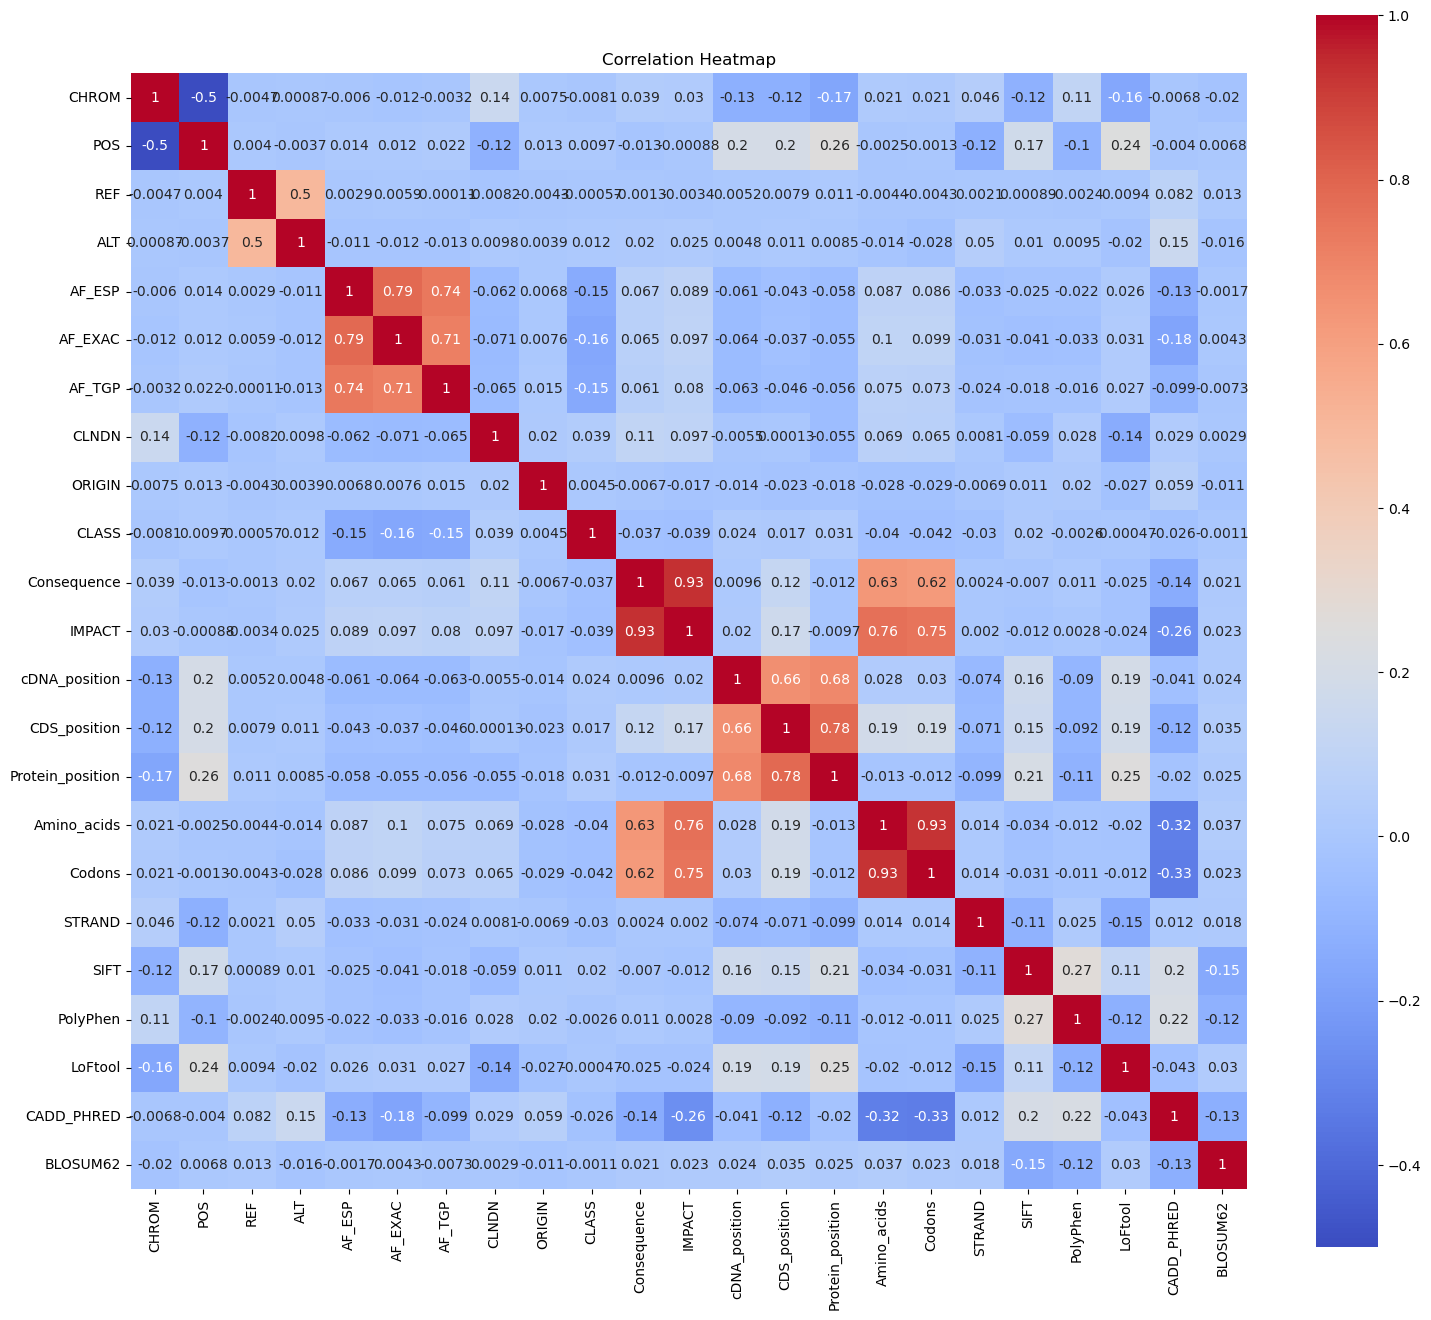

In [198]:
# Create a heatmap
plt.figure(figsize=(18, 16))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Set the title
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

The correlation heat map above highlights the presence of high correlations among certain variables. This scenario can have both positive and negative implications for the model. When the target variable exhibits strong correlations with features, it can indicate that these variables serve as reliable predictors. However, it is important to consider the possibility of collinearity issues, where high correlations between predictor variables might lead to multicollinearity concerns.

To address these dynamics, we will delve into feature engineering and feature selection methodologies, aiming to enhance the project's analytical capabilities. By employing strategic techniques, we can uncover valuable insights, optimize the predictive power of the selected features, and mitigate the potential impact of collinearity.

In [199]:
# Get the correlation matrix
corr_matrix = df.corr()

# Create a list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, column1 in enumerate(corr_matrix.columns):
    for j, column2 in enumerate(corr_matrix.columns):
        if i < j:  # Use i < j to avoid duplicate pairs
            correlation = abs(corr_matrix[column1][column2])
            if correlation > 0.15:  # Filter correlations above 0.10
                correlation_pairs.append((column1, column2, correlation))

# Sort correlation pairs by the absolute correlation in descending order
correlation_pairs.sort(key=lambda x: x[2], reverse=True)

print('Absolute Correlation Pairs:\n')
# Print the sorted correlation pairs
for pair in correlation_pairs:
    column1, column2, correlation = pair
    print(f"{column1} and {column2}: {correlation:.2f}")


Absolute Correlation Pairs:

Consequence and IMPACT: 0.93
Amino_acids and Codons: 0.93
AF_ESP and AF_EXAC: 0.79
CDS_position and Protein_position: 0.78
IMPACT and Amino_acids: 0.76
IMPACT and Codons: 0.75
AF_ESP and AF_TGP: 0.74
AF_EXAC and AF_TGP: 0.71
cDNA_position and Protein_position: 0.68
cDNA_position and CDS_position: 0.66
Consequence and Amino_acids: 0.63
Consequence and Codons: 0.62
CHROM and POS: 0.50
REF and ALT: 0.50
Codons and CADD_PHRED: 0.33
Amino_acids and CADD_PHRED: 0.32
SIFT and PolyPhen: 0.27
IMPACT and CADD_PHRED: 0.26
POS and Protein_position: 0.26
Protein_position and LoFtool: 0.25
POS and LoFtool: 0.24
PolyPhen and CADD_PHRED: 0.22
Protein_position and SIFT: 0.21
SIFT and CADD_PHRED: 0.20
POS and CDS_position: 0.20
POS and cDNA_position: 0.20
cDNA_position and LoFtool: 0.19
CDS_position and Codons: 0.19
CDS_position and LoFtool: 0.19
CDS_position and Amino_acids: 0.19
AF_EXAC and CADD_PHRED: 0.18
POS and SIFT: 0.17
CHROM and Protein_position: 0.17
IMPACT and CDS

# 3. Feature Selection and Model Build

### Algorithms and Models Used: 
1. Chi-Squared
2. PCA Reduction
3. Lasso Regression
4. Recursive Feature Elimination
5. Logistic Regression
6. Random Forest
7. XGBoost

## Target 1: CLASS (pathogenicity)

My focus is set on constructing the inaugural model with the esteemed target variable 'CLASS' at its core. This variable carries profound significance within the dataset as it adeptly categorizes mutations as either pathogenic (assigned the value 1) or non-pathogenic (assigned the value 0), effectively conveying critical insights. The binary nature of this variable further accentuates its pivotal role. Now, with enthusiasm brimming, let us embark on the enthralling exploration of variables that possess the inherent potential to serve as exemplary features in our model's framework.

In [200]:
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

# Exclude 'CLASS' from selected features
selected_features = [feature for feature in selected_features if feature != 'CLASS']

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")

Feature: AF_ESP, Score: 644.2181749822835
Feature: AF_EXAC, Score: 879.2203174205026
Feature: AF_TGP, Score: 681.2312400604945
Feature: CLNDN, Score: 23.421188968420292
Feature: Consequence, Score: 16.660527008265063
Feature: CDS_position, Score: 35.1087224401167
Feature: Protein_position, Score: 11.726915986482156
Feature: Amino_acids, Score: 14.152537035644079
Feature: Codons, Score: 18.463768253318978


In [201]:
df['AF_avg'] = (df['AF_ESP'] + df['AF_EXAC'] + df['AF_TGP']) / 3
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   ORIGIN            61281 non-null  int64  
 9   CLASS             61281 non-null  int64  
 10  Consequence       61281 non-null  int64  
 11  IMPACT            61281 non-null  int64  
 12  cDNA_position     61281 non-null  int64  
 13  CDS_position      61281 non-null  int64  
 14  Protein_position  61281 non-null  int64  
 15  Amino_acids       61281 non-null  int64  
 16  Codons            61281 non-null  int64 

In [202]:
corr_class = df[['CLASS', 'AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'Consequence',
               'Codons', 'STRAND', 'SIFT', 'LoFtool', 'BLOSUM62']]
corr_class.corr()

,CLASS,AF_avg,AF_ESP,AF_EXAC,AF_TGP,Consequence,Codons,STRAND,SIFT,LoFtool,BLOSUM62
CLASS,1.000000,-0.169083,-0.147515,-0.163028,-0.154419,-0.037220,-0.041860,-0.029929,0.020137,-0.000470,-0.001093
AF_avg,-0.169083,1.000000,0.922056,0.890509,0.916935,0.070144,0.092323,-0.031949,-0.028782,0.030596,-0.002608
AF_ESP,-0.147515,0.922056,1.000000,0.786559,0.736928,0.066842,0.086075,-0.033040,-0.024866,0.026369,-0.001652
AF_EXAC,-0.163028,0.890509,0.786559,1.000000,0.714909,0.065461,0.098826,-0.031182,-0.040622,0.030699,0.004292
AF_TGP,-0.154419,0.916935,0.736928,0.714909,1.000000,0.060524,0.073257,-0.024437,-0.018307,0.027461,-0.007256
Consequence,-0.037220,0.070144,0.066842,0.065461,0.060524,1.000000,0.622930,0.002400,-0.007018,-0.024852,0.021018
Codons,-0.041860,0.092323,0.086075,0.098826,0.073257,0.622930,1.000000,0.013703,-0.030541,-0.012300,0.023182
STRAND,-0.029929,-0.031949,-0.033040,-0.031182,-0.024437,0.002400,0.013703,1.000000,-0.108585,-0.148263,0.018062
SIFT,0.020137,-0.028782,-0.024866,-0.040622,-0.018307,-0.007018,-0.030541,-0.108585,1.000000,0.114566,-0.150985
LoFtool,-0.000470,0.030596,0.026369,0.030699,0.027461,-0.024852,-0.012300,-0.148263,0.114566,1.000000,0.030431


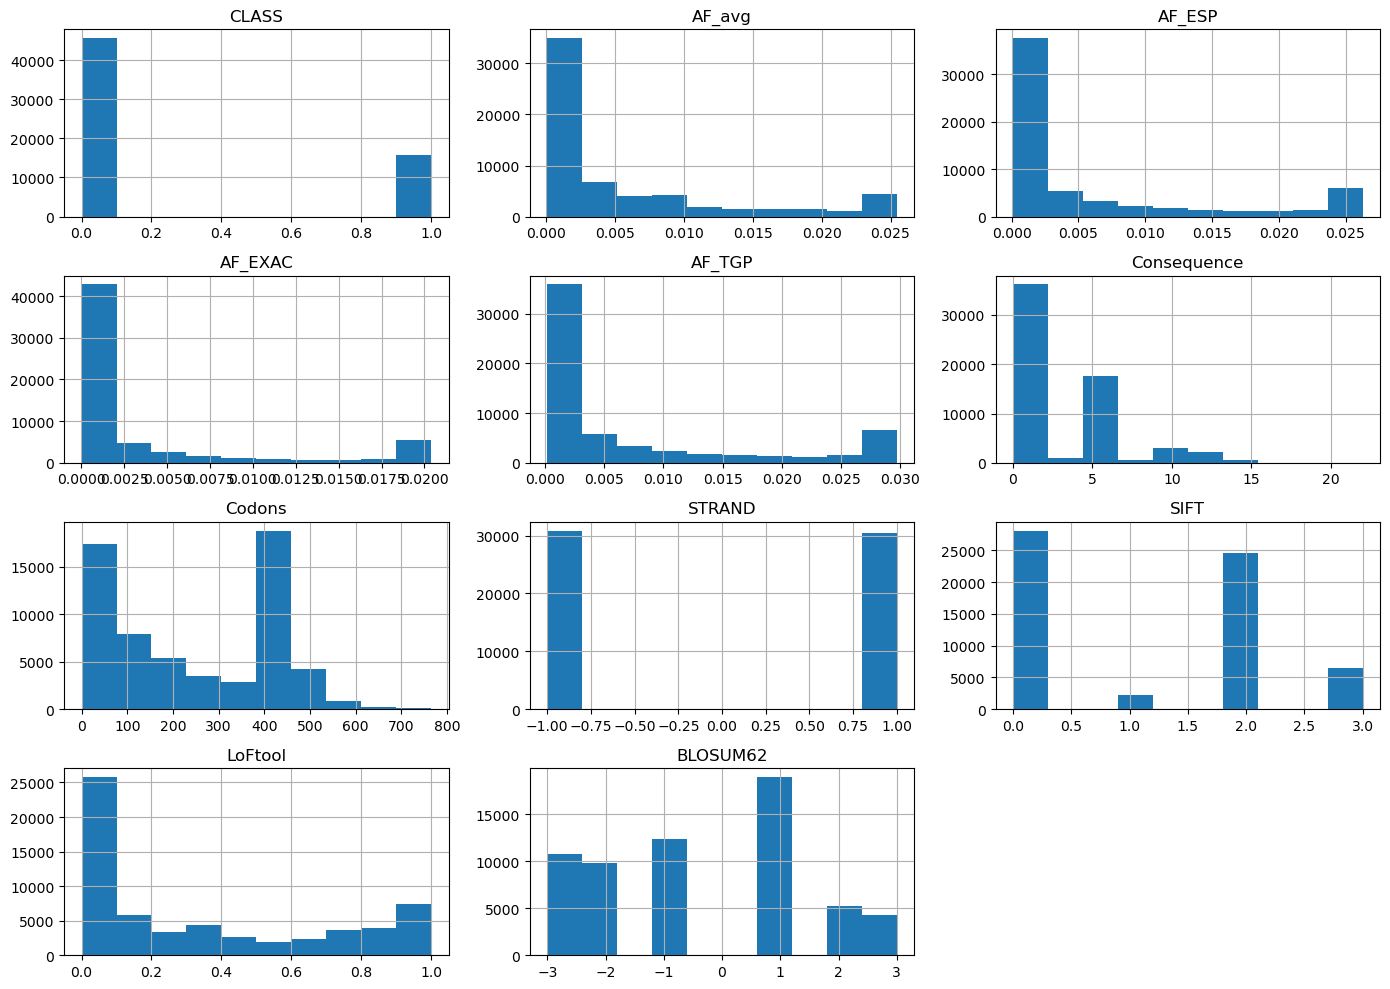

In [203]:
corr_class.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

The histogram above displays the distributions of columns within our new 'corr_class' dataframe. This dataframe is a subset of the main 'df' dataframe that contains the selected features from the chi-squared test regarding 'CLASS' as the potential target variable.

### Principal Component Analysis

In [204]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[['AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP']]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance.
 [0.87248892]


In an effort to explore the dimensionality of the data, I conducted a subset analysis focused on the three highly correlated allele frequency columns. These columns exhibit strong correlations with both the 'CLASS' variable and each other. Through Principal Component Analysis (PCA), I engineered a new variable, 'pca_1', which accounts for an impressive 87.25% of the total variance within the four allele columns. This finding suggests that a significant portion of the original variability can be effectively represented by this one-dimensional projection.

While the high explanatory power of 'pca_1' is promising, it is important to further investigate its suitability as a feature for our model. Merely capturing a substantial proportion of the variance does not guarantee its superiority. Thus, additional exploration and validation are necessary to assess its efficacy and relevance in our modeling efforts.

In [205]:
df[['AF_avg', 'pca_1', 'AF_ESP', 'AF_EXAC', 'AF_TGP']].corr()

,AF_avg,pca_1,AF_ESP,AF_EXAC,AF_TGP
AF_avg,1.000000,0.999065,0.922056,0.890509,0.916935
pca_1,0.999065,1.000000,0.923808,0.908127,0.902059
AF_ESP,0.922056,0.923808,1.000000,0.786559,0.736928
AF_EXAC,0.890509,0.908127,0.786559,1.000000,0.714909
AF_TGP,0.916935,0.902059,0.736928,0.714909,1.000000


In [206]:
df_new = df.copy()

# Drop the specified columns
df_new.drop(['AF_ESP', 'AF_EXAC', 'AF_avg', 'AF_TGP'], axis=1, inplace=True)

X = df_new.drop('CLASS', axis=1)
y = df_new['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_new.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")

Feature: CLNDN, Score: 23.421188968420292
Feature: CLASS, Score: 16.660527008265063
Feature: Consequence, Score: 35.1087224401167
Feature: IMPACT, Score: 7.151653109976438
Feature: CDS_position, Score: 11.726915986482156
Feature: Protein_position, Score: 14.152537035644079
Feature: Amino_acids, Score: 18.463768253318978
Feature: Codons, Score: 27.61327836250723
Feature: STRAND, Score: 9.026061821253077
Feature: BLOSUM62, Score: 720.8357929510004


The pca variable was not selected as a feature by the Chi-Squared Test.

In [207]:
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: AF_ESP, Score: 644.2181749822835
Feature: AF_EXAC, Score: 879.2203174205026
Feature: AF_TGP, Score: 681.2312400604945
Feature: CLNDN, Score: 23.421188968420292
Feature: CLASS, Score: 16.660527008265063
Feature: Consequence, Score: 35.1087224401167
Feature: Amino_acids, Score: 18.463768253318978
Feature: Codons, Score: 27.61327836250723
Feature: BLOSUM62, Score: 710.5914354496867
Feature: AF_avg, Score: 720.8357929510004


The results of the chi-squared test that includes all frequency columns revealed the selection of the allele frequency columns as significant features, contrary to our previous attempt. Despite the high correlations among the allele frequencies, the 'AF_avg' column emerged as a standout feature with a high score.

Considering the persisting collinearity among the remaining allele frequency columns, I have made the definitive decision to retain only the 'AF_avg' column in order to mitigate collinearity issues. This strategic choice aims to enhance the independence of the selected features and improve the overall robustness of our model.

### AF Statistical Significance 

In [208]:
# Perform t-test between 'AF_avg' and 'AF_ESP'
t_statistic_es, p_value_es = stats.ttest_ind(df['AF_avg'], df['AF_ESP'], equal_var=False)
print("T-test results: AF_avg vs AF_ESP")
print(f"t-statistic: {t_statistic_es}")
print(f"p-value: {p_value_es}\n")

# Perform t-test between 'AF_avg' and 'AF_EXAC'
t_statistic_exac, p_value_exac = stats.ttest_ind(df['AF_avg'], df['AF_EXAC'], equal_var=False)
print("T-test results: AF_avg vs AF_EXAC")
print(f"t-statistic: {t_statistic_exac}")
print(f"p-value: {p_value_exac}\n")

# Perform t-test between 'AF_avg' and 'AF_TGP'
t_statistic_tgp, p_value_tgp = stats.ttest_ind(df['AF_avg'], df['AF_TGP'], equal_var=False)
print("T-test results: AF_avg vs AF_TGP")
print(f"t-statistic: {t_statistic_tgp}")
print(f"p-value: {p_value_tgp}\n")


T-test results: AF_avg vs AF_ESP
t-statistic: -7.265394688487112
p-value: 3.7418880787747494e-13

T-test results: AF_avg vs AF_EXAC
t-statistic: 50.302130265165076
p-value: 0.0

T-test results: AF_avg vs AF_TGP
t-statistic: -33.0355226075503
p-value: 3.341591294453654e-238



C:\Users\Jody\AppData\Local\Temp\ipykernel_36156\647185842.py:2: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_es, p_value_es = stats.ttest_ind(df['AF_avg'], df['AF_ESP'], equal_var=False)
C:\Users\Jody\AppData\Local\Temp\ipykernel_36156\647185842.py:8: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_exac, p_value_exac = stats.ttest_ind(df['AF_avg'], df['AF_EXAC'], equal_var=False)
C:\Users\Jody\AppData\Local\Temp\ipykernel_36156\647185842.py:14: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_tgp, p_value_tgp = stats.ttest_ind(df['AF_avg'], df['AF_TGP'], equal_var=False)


An additional test was conducted to compare the 'AF_avg' column with the other allele frequency columns. Regrettably, the statistical analysis reveals significant differences, thus introducing complexities into the model development process. While retaining the allele frequency columns entails certain risks due to potential collinearity concerns, for the current project, the decision to drop these columns has been made to mitigate this issue. However, it is imperative to acknowledge that the topic of allele frequency discrepancies warrants further investigation to unravel its intricacies fully. The emerging findings from my data analysis underscore the divergence in allele frequency measurements across different databases, leading to potential misclassification of diseases by medical practitioners.

In [209]:
df_three = df.copy()
df_three.drop(['AF_ESP', 'AF_TGP', 'AF_EXAC'], axis=1, inplace=True)

X = df_three.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_three.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: CLNDN, Score: 23.421188968420292
Feature: CLASS, Score: 16.660527008265063
Feature: Consequence, Score: 35.1087224401167
Feature: CDS_position, Score: 11.726915986482156
Feature: Protein_position, Score: 14.152537035644079
Feature: Amino_acids, Score: 18.463768253318978
Feature: Codons, Score: 27.61327836250723
Feature: STRAND, Score: 9.026061821253077
Feature: BLOSUM62, Score: 710.5914354496867
Feature: AF_avg, Score: 720.8357929510004


### Logistic Regression

In [210]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7433303418454761
Precision: 0.7433303418454761
Recall: 0.7433303418454761
F1 Score: 0.7433303418454761
Confusion Matrix:
[[9111    0]
 [3146    0]]


The logistic regression model achieved an accuracy of 0.743. However, a detailed examination of the confusion matrix, precision, recall score and F1 score revealed reveled to all be identical to the accuracy value. This occurs when a model is performed on an imbalanced dataset. In this particular dataset, the CLASS variable is binary, and the two values are imbalanced. To address this, we will explore the implementation of Lasso regression to further improve the model's predictive performance and enhance its ability to extract meaningful insights from the data.

### Lasso Coefficients and Regression

In [211]:
# Define your feature matrix X and target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Apply feature scaling if needed
# X = StandardScaler().fit_transform(X)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso.fit(X, y)

# Get the coefficients and corresponding feature names
coefficients = lasso.coef_
feature_names = X.columns

# Print the selected features and their coefficients
selected_features = [(name, coef) for name, coef in zip(feature_names, coefficients) if coef != 0]
print("Selected Features:")
for name, coef in selected_features:
    print(name, ":", coef)

Selected Features:
POS : 5.947833349074802e-11
CLNDN : 7.213245715279824e-06
cDNA_position : 7.317498138988733e-07
CDS_position : -1.3770886404526525e-06
Protein_position : 1.0829733903382228e-05
Codons : -0.00011412032004891895
CADD_PHRED : -0.00113048198002981
pca_1 : -0.009844368477534716


In [212]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001)  # alpha is the regularization strength
lasso.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lasso.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 0.18425791643372363
R-squared (R2): 0.03423877823918409


These results indicate that the Lasso regression model might not be a good fit for the data. The relatively low R2 suggest that the model may not be capturing the underlying patterns well and is not able to explain a substantial amount of the variance in the target variable. It might be necessary to explore other regression models or consider different approaches to improve the predictive performance for your specific dataset.

Up next is Recursive Feature Elimination.

### Recursive Feature Elimination (RFE)

In [213]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the classifier (e.g., Logistic Regression)
classifier = LogisticRegression()

# Create an instance of RFE with the classifier and the desired number of features to keep
rfe = RFE(estimator=classifier, n_features_to_select=5)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features from RFE
selected_features = X_train.columns[rfe.support_]

# Create a new feature matrix with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create and fit the logistic regression model using the selected features
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_selected)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)

Mean Squared Error (MSE): 0.25666965815452397
R-squared (R2): -0.34529689386455953
Accuracy: 0.7433303418454761
Precision: 0.7433303418454761
Recall: 0.7433303418454761
F1 Score: 0.7433303418454761
Confusion Matrix:
[[9111    0]
 [3146    0]]
Selected Features:
POS
CLNDN
cDNA_position
CDS_position
Protein_position


Recursive Feature Elimination has obtained an accuracy of 74.3%. However, all metric scores are calculated as the same again. The RFE model, similar to logistic regression, is struggling to handle the imbalanced CLASS values.

### Random Forest

In [214]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Get the feature importances
importances = rf_classifier.feature_importances_

# Get the indices of the most important features (top k features)
k = 10
top_k_indices = importances.argsort()[-k:][::-1]

# Get the names of the selected features
selected_features = X.columns[top_k_indices]

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Selected Features:")
for feature in selected_features:
    print(feature)

Accuracy: 0.7549971444888635
Mean Squared Error (MSE): 0.24500285551113649
R-squared (R2): -0.28414703505253414
Selected Features:
AF_EXAC
CLNDN
POS
pca_1
AF_avg
CADD_PHRED
AF_TGP
cDNA_position
Protein_position
CDS_position


### XGBoost

In [215]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Gradient Boosting classifier with subsampling
gb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gb_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Get the feature importances
importances = gb_classifier.feature_importances_

# Get the indices of the most important features (top k features)
k = 10
top_k_indices = importances.argsort()[-k:][::-1]

# Get the names of the selected features
selected_features = X.columns[top_k_indices]

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)
print("Selected Features:")
for feature in selected_features:
    print(feature)


Mean Squared Error (MSE): 0.23839438688096598
R-squared (R2): -0.2495097024387296
Accuracy: 0.7616056131190341
Selected Features:
IMPACT
pca_1
AF_EXAC
Consequence
CLNDN
AF_TGP
LoFtool
AF_avg
ORIGIN
CADD_PHRED


Despite applying various techniques, our models show limited success, with similar accuracy scores peaking at 0.761 However, error scores reveal that these models barely outperform mean-based predictions. A mix of shared and unique features is seen across models. At this point, I'm pausing further work on this target due to its imbalanced binary nature, with a notably higher occurrence of '0' values - a challenge for future resolution.

## Target 2: PolyPhen (missense mutations)

The next target variable that has piqued my interest is the PolyPhen variable. This categorical attribute encapsulates the projected implications of genetic variations, specifically missense mutations, on protein structure and functionality. It categorizes variants into "benign", "possibly damaging", or "probably damaging", thereby providing insightful interpretations drawn from diverse protein sequence and structure-based features.

In [216]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  object 
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  object 
 3   ALT               61281 non-null  object 
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  object 
 8   CLNVC             61281 non-null  object 
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  object 
 12  IMPACT            61281 non-null  object 
 13  cDNA_position     61281 non-null  object 
 14  CDS_position      61281 non-null  object 
 15  Protein_position  61281 non-null  object 
 16  Amino_acids       61281 non-null  object

PolyPhen (Polymorphism Phenotyping) is a computational tool used in bioinformatics for predicting the possible impact of an amino acid substitution on the structure and function of a human protein. This tool helps in determining whether a specific genetic mutation (variant) within a gene might be harmful (pathogenic), thus aiding in the study of disease genetics.

It classifies the variants into three categories:

1. "Benign": The variant is likely harmless.
2. "Possibly Damaging": The variant could potentially be harmful, but there's some uncertainty.
3. "Probably Damaging": The variant is likely to be harmful.

PolyPhen utilizes a machine learning model that incorporates a variety of protein sequence and structural features to make these classifications, thus assisting researchers and clinicians in the interpretation of genetic variants in humans.

For this project, PolyPhen will be analyzed alongside the Consequence column. The Consequence column provides the exact type of mutation. A significant portion of these values are classified as a missense variant.

Why do we care about missense variants?

Missense variants are a very common result of genetic mutations. Many missense variants have been linked to a variety of genetic diseases, including cystic fibrosis, sickle cell disease, and various forms of cancer. Identifying these variants can help in diagnosing these diseases or understanding their molecular basis. Furthermore, the study of missense variants can contribute to the development of targeted treatments and precision medicine strategies.

In [217]:
df_original['Consequence'].nunique()

23

In [218]:
# Count the unique values
value_counts = df_original['Consequence'].value_counts()

# Print the count of each unique value
print(value_counts)

missense_variant                                31320
synonymous_variant                              17666
intron_variant                                   3900
splice_region_variant&intron_variant             3021
stop_gained                                      1685
missense_variant&splice_region_variant            961
5_prime_UTR_variant                               580
splice_region_variant&synonymous_variant          552
splice_donor_variant                              515
3_prime_UTR_variant                               384
splice_acceptor_variant                           382
start_lost                                         92
upstream_gene_variant                              77
stop_gained&splice_region_variant                  69
downstream_gene_variant                            22
splice_region_variant&5_prime_UTR_variant          15
intergenic_variant                                 14
stop_lost                                          10
stop_retained_variant       

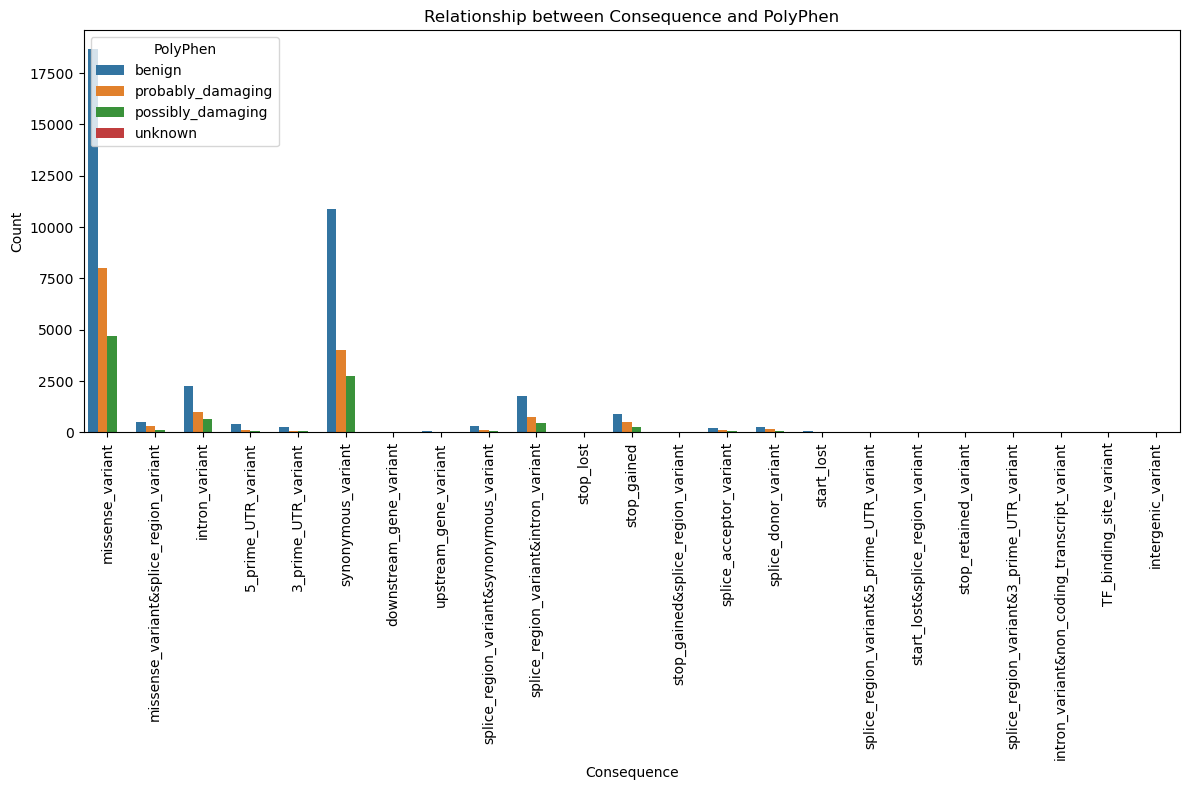

In [219]:
# Create a count plot
plt.figure(figsize=(12, 8))
sns.countplot(x='Consequence', hue='PolyPhen', data=df_original)
plt.xlabel('Consequence')
plt.ylabel('Count')
plt.title('Relationship between Consequence and PolyPhen')
plt.xticks(rotation=90)  # Increase rotation value for better readability
plt.legend(title='PolyPhen')
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


A count plot was generated above to explore the relationship between the Consequence and PolyPhen features. By visual inspection, missense variant mutations have the highest total sample count as well as the highest counts of probably and possibly damaging PoylPhen results.

In [220]:
# Filter the dataframe
df_filtered = df_original[df_original['Consequence'].str.startswith('missense')]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32281 non-null  object 
 1   POS               32281 non-null  int64  
 2   REF               32281 non-null  object 
 3   ALT               32281 non-null  object 
 4   AF_ESP            32281 non-null  float64
 5   AF_EXAC           32281 non-null  float64
 6   AF_TGP            32281 non-null  float64
 7   CLNDN             32281 non-null  object 
 8   CLNVC             32281 non-null  object 
 9   ORIGIN            32281 non-null  int64  
 10  CLASS             32281 non-null  int64  
 11  Consequence       32281 non-null  object 
 12  IMPACT            32281 non-null  object 
 13  cDNA_position     32281 non-null  object 
 14  CDS_position      32281 non-null  object 
 15  Protein_position  32281 non-null  object 
 16  Amino_acids       32281 non-null  object

In [221]:
# encode object variables for model build

df_factorized = df_filtered.copy()

# Iterate over each column in the dataframe
for column in df_factorized.columns:
    # Check if the column's dtype is 'object'
    if df_factorized[column].dtype == 'object':
        df_factorized[column] = pd.factorize(df_factorized[column])[0]

df_factorized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32281 non-null  int64  
 1   POS               32281 non-null  int64  
 2   REF               32281 non-null  int64  
 3   ALT               32281 non-null  int64  
 4   AF_ESP            32281 non-null  float64
 5   AF_EXAC           32281 non-null  float64
 6   AF_TGP            32281 non-null  float64
 7   CLNDN             32281 non-null  int64  
 8   CLNVC             32281 non-null  int64  
 9   ORIGIN            32281 non-null  int64  
 10  CLASS             32281 non-null  int64  
 11  Consequence       32281 non-null  int64  
 12  IMPACT            32281 non-null  int64  
 13  cDNA_position     32281 non-null  int64  
 14  CDS_position      32281 non-null  int64  
 15  Protein_position  32281 non-null  int64  
 16  Amino_acids       32281 non-null  int64 

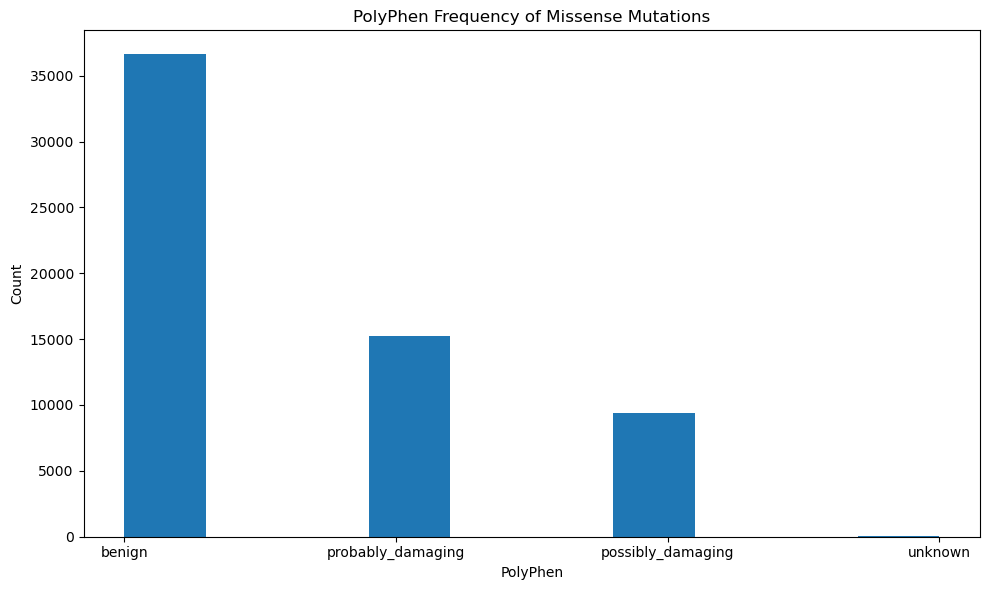

In [222]:
# Generate bar plot for 'PolyPhen'
plt.figure(figsize=(10, 6))
plt.hist(df_original['PolyPhen'])
plt.xlabel('PolyPhen')
plt.ylabel('Count')
plt.title('PolyPhen Frequency of Missense Mutations')

plt.tight_layout()
plt.show()

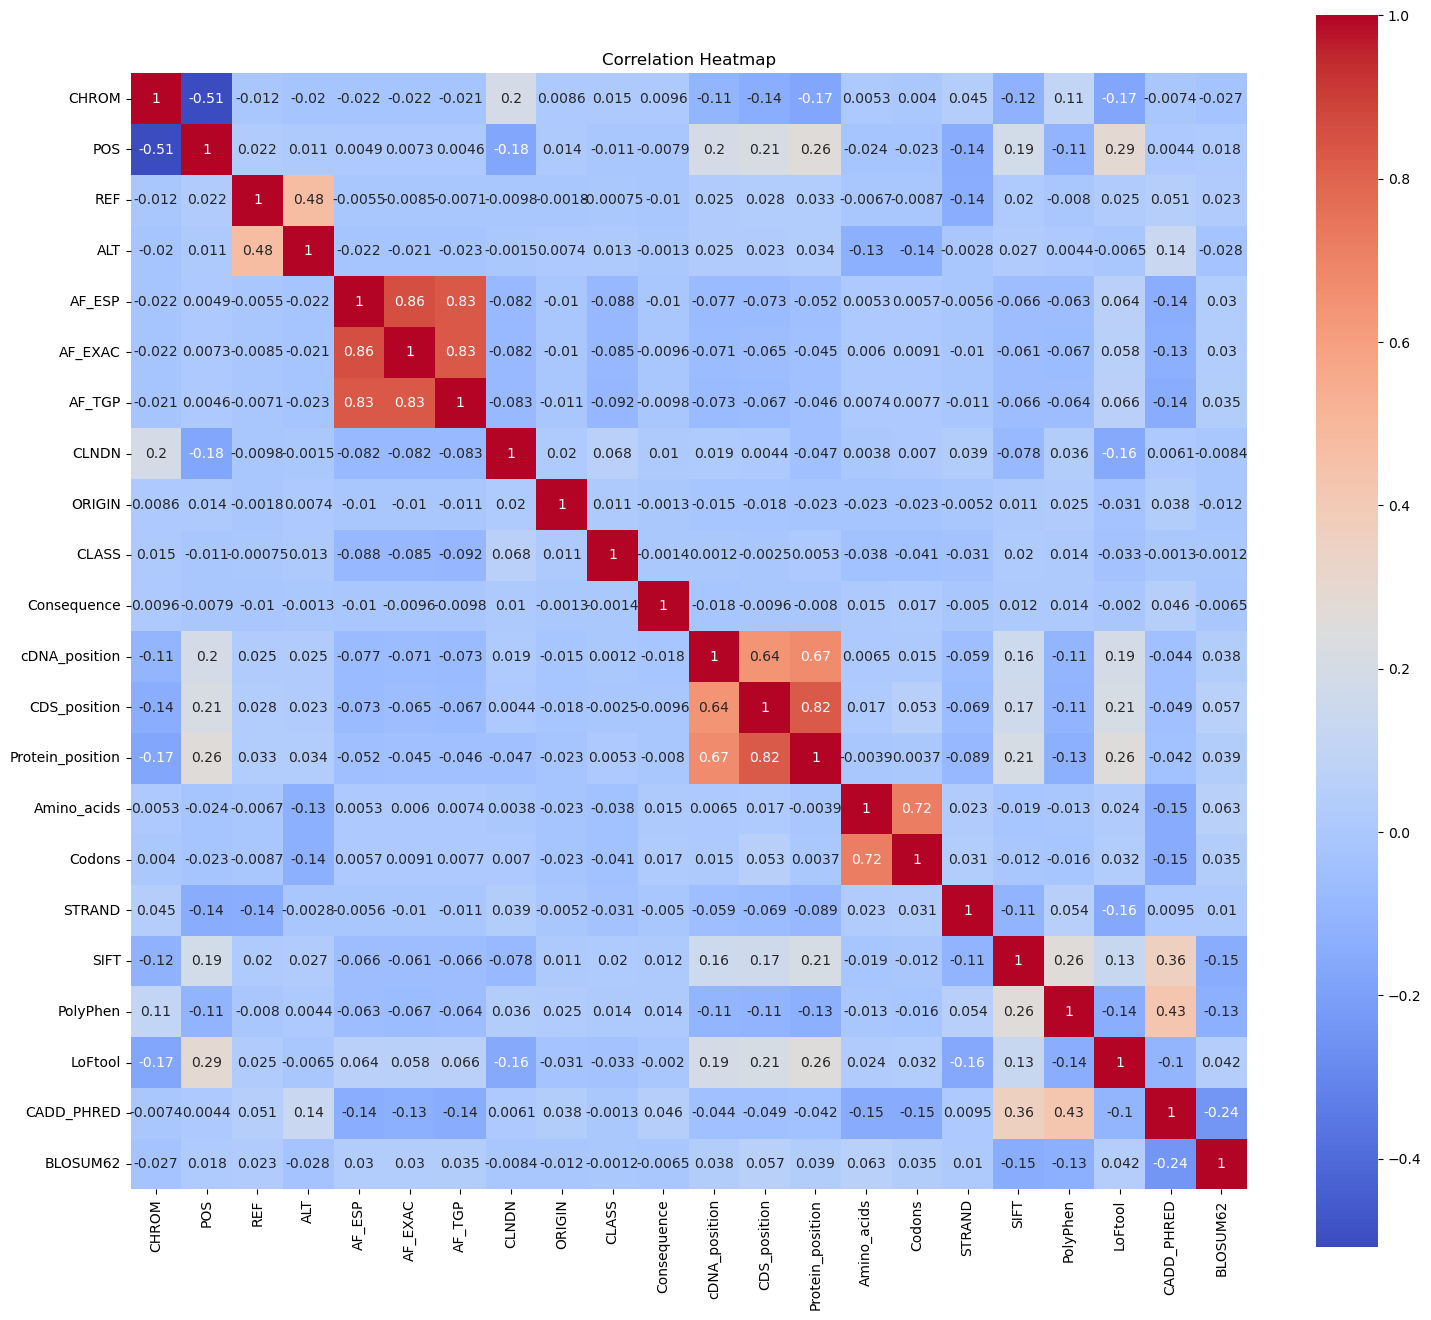

In [223]:
df_factorized.drop(['IMPACT', 'CLNVC'], axis=1, inplace=True)

# Create a heatmap
plt.figure(figsize=(18, 16))

correlation_matrix = df_factorized.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [224]:
df_factorized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32281 entries, 0 to 65187
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32281 non-null  int64  
 1   POS               32281 non-null  int64  
 2   REF               32281 non-null  int64  
 3   ALT               32281 non-null  int64  
 4   AF_ESP            32281 non-null  float64
 5   AF_EXAC           32281 non-null  float64
 6   AF_TGP            32281 non-null  float64
 7   CLNDN             32281 non-null  int64  
 8   ORIGIN            32281 non-null  int64  
 9   CLASS             32281 non-null  int64  
 10  Consequence       32281 non-null  int64  
 11  cDNA_position     32281 non-null  int64  
 12  CDS_position      32281 non-null  int64  
 13  Protein_position  32281 non-null  int64  
 14  Amino_acids       32281 non-null  int64  
 15  Codons            32281 non-null  int64  
 16  STRAND            32281 non-null  float6

### Model Build (same as CLASS model)

In [225]:
X = df_factorized.drop('PolyPhen', axis=1)
y = df_factorized['PolyPhen']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")
    

Feature: CHROM, Score: 91.83139665532157
Feature: AF_EXAC, Score: 98.37495211901782
Feature: AF_TGP, Score: 101.46518825400895
Feature: IMPACT, Score: 101.91282165167553
Feature: cDNA_position, Score: 118.85309448788595
Feature: CDS_position, Score: 146.86993896382413
Feature: STRAND, Score: 1449.1632290623747
Feature: SIFT, Score: 314.38123161415723
Feature: PolyPhen, Score: 1186.8851100003626
Feature: LoFtool, Score: 214.72414527202199


In [226]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Print the selected features
selected_features = df.columns[selected_indices]
print("Selected Features:")
for feature in selected_features:
    print(feature)

Accuracy: 0.7216973826854577
Precision: 0.7216973826854577
Recall: 0.7216973826854577
Selected Features:
CHROM
AF_EXAC
AF_TGP
IMPACT
cDNA_position
CDS_position
STRAND
SIFT
PolyPhen
LoFtool


C:\Users\Jody\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [227]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001) 
lasso.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lasso.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 0.41255609143716104
R-squared (R2): 0.24188508566910394


In [228]:
X = df_factorized.drop('PolyPhen', axis=1)
y = df_factorized['PolyPhen']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Gradient Boosting classifier
gb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_xg = gb_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_xg)
# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred_xg)
# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred_xg)

# Get the selected features
selected_features = df_factorized.drop('PolyPhen', axis=1).columns

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)


# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)


Selected Features:
CHROM
POS
REF
ALT
AF_ESP
AF_EXAC
AF_TGP
CLNDN
ORIGIN
CLASS
Consequence
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
STRAND
SIFT
LoFtool
CADD_PHRED
BLOSUM62
Mean Squared Error (MSE): 0.42821743843890353
R-squared (R2): 0.21310572454230092
Accuracy: 0.788136905683754


In [229]:
# Make predictions on the testing set
y_pred_xg = gb_classifier.predict(X_test)

# Create the confusion matrix
confusion = confusion_matrix(y_test, y_pred_xg)
print(confusion)


[[3509  175   79    0]
 [ 275 1366   91    0]
 [ 384  363  214    0]
 [   1    0    0    0]]


In [230]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

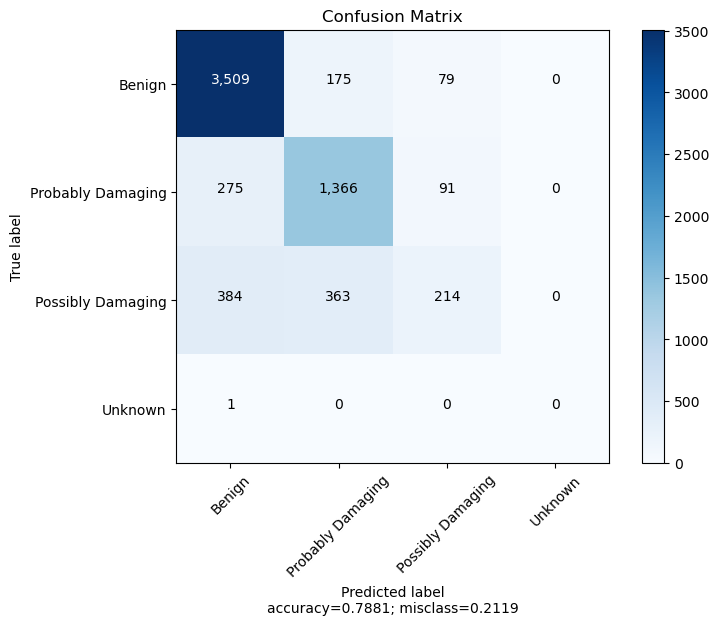

In [231]:
plot_confusion_matrix(cm=confusion, target_names = ['Benign', 'Probably Damaging', 'Possibly Damaging', 'Unknown'], title = 'Confusion Matrix',normalize=False)

XGBoost performed the best on the data and was used to build the classification model of the 'PolyPhen' target variable. Accuracy is 78.8%.

## Target 3: Consequence (resulting mutation)

Per the last target (PolyPhen), Consequence proves to be very important in classifying the potential damage of genetic mutations. Let's analyze the Consequence column as a whole, as opposed to strictly missense mutations.

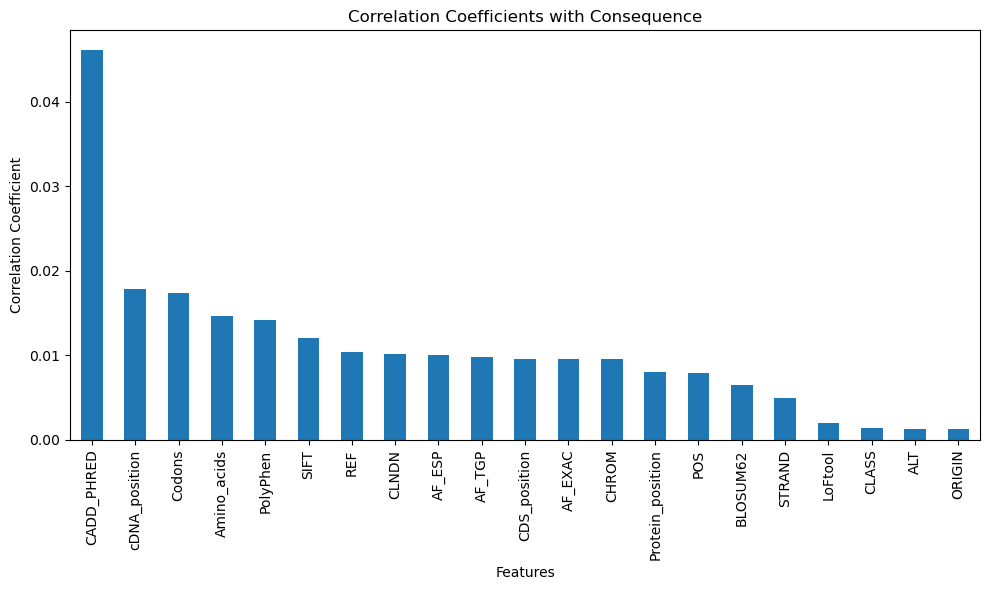

In [232]:
# Calculate the correlation coefficients
correlation_matrix = df_factorized.corr()
correlation_values = correlation_matrix['Consequence'].abs()

# Sort the correlation values in descending order
sorted_correlations = correlation_values.sort_values(ascending=False)

# Plot the sorted correlation coefficients
plt.figure(figsize=(10, 6))
sorted_correlations = sorted_correlations.drop('Consequence')
sorted_correlations.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients with Consequence')
plt.tight_layout()
plt.show()

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61281 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   ORIGIN            61281 non-null  int64  
 9   CLASS             61281 non-null  int64  
 10  Consequence       61281 non-null  int64  
 11  IMPACT            61281 non-null  int64  
 12  cDNA_position     61281 non-null  int64  
 13  CDS_position      61281 non-null  int64  
 14  Protein_position  61281 non-null  int64  
 15  Amino_acids       61281 non-null  int64  
 16  Codons            61281 non-null  int64 

### Model Build

In [234]:
# Separate the feature matrix X and the target variable y
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# Create and fit the Lasso regression model
lasso = Lasso(alpha=0.01)  # alpha is the regularization strength
lasso.fit(X, y)

# Get the feature importance scores
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
sorted_coef = lasso_coef.abs().sort_values(ascending=False)

# Print the sorted feature importance scores
print("Sorted Feature Importance Scores:")
print(sorted_coef)


Sorted Feature Importance Scores:
IMPACT              3.644115e+00
ALT                 6.994597e-02
PolyPhen            3.380137e-02
SIFT                3.137545e-02
CADD_PHRED          2.839463e-02
BLOSUM62            1.587991e-02
REF                 8.983891e-03
pca_1               7.474237e-03
Amino_acids         5.286939e-03
CHROM               2.855687e-03
Codons              1.314255e-03
ORIGIN              7.031344e-04
Protein_position    9.526619e-05
CDS_position        5.713235e-05
CLNDN               1.625339e-05
cDNA_position       6.329919e-06
POS                 4.266609e-10
CLASS               0.000000e+00
STRAND              0.000000e+00
AF_TGP              0.000000e+00
LoFtool             0.000000e+00
AF_EXAC             0.000000e+00
AF_ESP              0.000000e+00
AF_avg              0.000000e+00
dtype: float64


In [235]:
from sklearn.metrics import accuracy_score

# Separate the feature matrix X and the target variable y
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the XGBoost classification model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)

Mean Squared Error (MSE): 0.50493595496451
R-squared (R2): 0.9568414949816615
Accuracy: 0.9344048298931223
Selected Features:
CHROM
POS
REF
ALT
AF_ESP
AF_EXAC
AF_TGP
CLNDN
ORIGIN
CLASS
Consequence
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
STRAND
SIFT
LoFtool
CADD_PHRED
BLOSUM62


RESULTS:

1. Accuracy: An excellent score of 93.4% signifies that the model was able to correctly predict the outcomes in the majority of the cases, thus demonstrating a strong ability to differentiate between classes in our dataset.

2. R-squared: The substantial value of 0.957 confirms the model's robustness, suggesting that approximately 95.7% of the variance in the dependent variable can be explained by the independent variables. This is an indicator of the model's exceptional goodness of fit.

3. Mean Squared Error (MSE): The low MSE of 0.505 signifies that the model's predictions are close to the actual values, demonstrating its capability to make precise predictions.

## 4. Final Model Prediction Visualizations

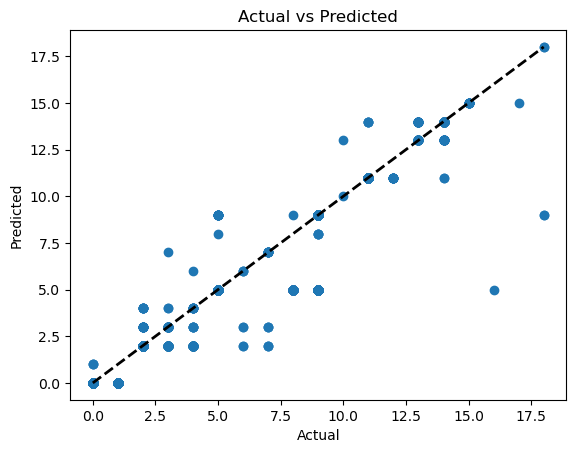

In [236]:
# Create a plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

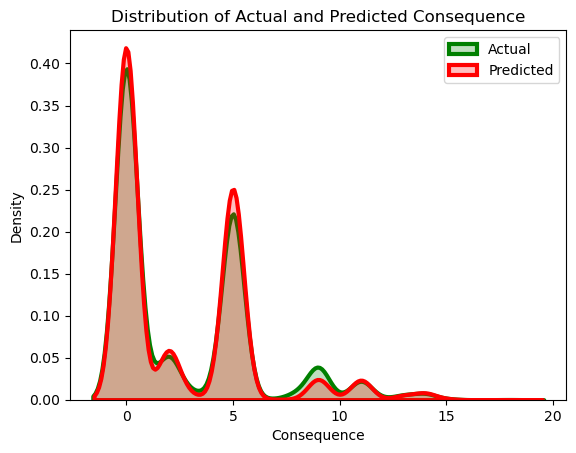

In [237]:
# Create a plot of the distribution of predicted values
sns.kdeplot(y_test, label='Actual', color='g', shade=True, linewidth=3)
sns.kdeplot(y_pred, label='Predicted', color='r', shade=True, linewidth=3)
plt.xlabel('Consequence')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Consequence')
plt.legend()
plt.show()

# 5. Conclusion

The research project sought to examine the relationship between the pathogenicity of genetic mutations and the classification of genetic diseases using the ClinVar database. We embarked on a rigorous data cleaning process, handling missing values, identifying outliers, and removing redundant or irrelevant columns. A keen focus on the dataset's allele frequency measures (AF_ESP, AF_EXAC, and AF_TGP) revealed differing counts of null values and potential collinearity issues, leading us to engineer a new feature to capture to mean of all columns considering they represent the same theoretical value.

We applied various machine learning models, including Chi-Squared, PCA Reduction, Lasso Regression, Recursive Feature Elimination, Logistic Regression, Random Forest, and XGBoost to our refined dataset. Initial results produced an accuracy of 0.76 and an R-square value of -0.25. The error scores were less than optimal due in part to the imbalanced binary nature of the 'CLASS' variable.

However, subsequent analysis of the PolyPhen variable, which categorizes the projected implications of genetic variations on protein structure and functionality, yielded more promising results. Our XGBoost model achieved an accuracy of 78.8% for this target and an R-squared value of 0.21. Analysis of the 'Consequence' column, detailing the specific types of mutations, further enhanced our understanding of genetic mutation classifications.

A final model built using the 'Consequence' column as a target, achieved an impressive accuracy of 93.4%. The R-squared value of 0.957 signified that the model could explain 95.7% of the variance in the dependent variable, while the low MSE value of 0.505 pointed to a close fit between the model predictions and actual results.

In conclusion, our findings underscore the complexity of genetic mutation classifications and the potential of machine learning to enhance our understanding of these variations. While initial results were challenging, subsequent analyses of different variables provided promising insights, laying the groundwork for future research in genetic disease classification.